In [1]:
# the key idea is that instead of doing L2 training we do sobolev training ! 

# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.17.2
#   kernelspec:
#     display_name: .venv
#     language: python
#     name: python3
# ---

In [2]:
from sciml.model.deeponet import DeepONet
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sciml.data.preprocessing.process_given_dataset import get_mu_xs_sol

tf.config.list_physical_devices('GPU')

2025-08-06 10:10:27.472154: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-06 10:10:27.503208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754489427.517211  252432 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754489427.521269  252432 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754489427.534540  252432 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
d_p = 40
d_V = 40
epochs = 10

In [4]:
internal_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(100,)),
    tf.keras.layers.Reshape((100, 1)),  # we reshape to (batch, 100, 1)
    tf.keras.layers.Conv1D(128, kernel_size=5, activation='elu', padding='same'),
    tf.keras.layers.Conv1D(128, kernel_size=5, activation='elu', padding='same'),
    tf.keras.layers.Conv1D(32, kernel_size=5, activation='elu', padding='same'),
    tf.keras.layers.GlobalAveragePooling1D(),  # we aggregate to (batch, 32)
    tf.keras.layers.Dense(d_V, activation='elu')  # we output d_V features
])

external_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(1,)),
    tf.keras.layers.Reshape((1, 1)),  # we reshape to (batch, 1, 1) for Conv1D
    tf.keras.layers.Conv1D(32, kernel_size=1, activation='elu'),  # we use kernel_size=1
    tf.keras.layers.Conv1D(32, kernel_size=1, activation='elu'),  # we use kernel_size=1
    tf.keras.layers.Flatten(),  # we flatten back to (batch, 32)
    tf.keras.layers.Dense(d_V, activation='elu')  # we output d_V features
])


I0000 00:00:1754489430.342574  252432 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


trying to enforce the boundary condition

In [5]:
class ConstrainedExternalModel(tf.keras.Model):
    def __init__(self, base_model, d_V):
        super().__init__()
        self.base_model = base_model
        self.d_V = d_V
    
    def call(self, x):
        """
        External model with boundary constraints: forces solution to be 0 at x=0 and x=1
        Uses basis functions that vanish at boundaries: x*(1-x), x^2*(1-x), etc.
        """
        # we get the base model output for learnable coefficients
        base_output = self.base_model(x)  # shape: (batch*n_points, d_V-1)
        
        # we extract x coordinates 
        x_coords = tf.squeeze(x, axis=-1)  # shape: (batch*n_points,)
        
        # we create basis functions that vanish at boundaries
        # First basis: x*(1-x) - vanishes at both x=0 and x=1
        basis_boundary = tf.expand_dims(x_coords * (1.0 - x_coords), axis=1)
        
        # we multiply all learned bases by x*(1-x) to ensure they vanish at boundaries
        x_factor = tf.expand_dims(x_coords * (1.0 - x_coords), axis=1)
        constrained_bases = base_output * x_factor
        
        # we concatenate: [x*(1-x), constrained_bases...]
        constrained_output = tf.concat([basis_boundary, constrained_bases], axis=1)
        
        return constrained_output

# we create the normal internal model (no constraints needed)
internal_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(100,)),
    tf.keras.layers.Dense(d_V, activation='elu'),
    tf.keras.layers.Dense(d_V, activation='elu'),
    tf.keras.layers.Dense(d_V, activation='elu'),
    tf.keras.layers.Dense(d_V, activation='elu'),
    tf.keras.layers.Dense(d_V, activation='elu')
    # full d_V output
])

# we create the constrained external model
base_external = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(1,)),
    tf.keras.layers.Dense(512, activation='elu',kernel_initializer='he_normal'),
    tf.keras.layers.Dense(256, activation='elu',kernel_initializer='he_normal'),
    tf.keras.layers.Dense(256, activation='elu',kernel_initializer='he_normal'),
    tf.keras.layers.Dense(d_V-1, activation='elu')  # we reduce by 1 for the boundary basis
])

external_model = ConstrainedExternalModel(base_external, d_V)

In [6]:
folder_path = "/home/janis/SCIML/summerschool/data/benchmarks/given/"
coeff = tf.constant([-0.01,0.2,0],dtype=tf.float32)

In [7]:
model = DeepONet(regular_params={"internal_model": internal_model, "external_model": external_model}, hyper_params={"pinn_order":2,"pinn_coeff": coeff,"d_p": d_p, "d_V": d_V,"device": "GPU","n_epochs":epochs},folder_path="/home/janis/SCIML/summerschool/data/benchmarks/given/")

2025-08-06 10:10:31,189 - sciml.model.deeponet.deeponet - INFO - Model initialized with 10 epochs, 32 batch size, 0.001 learning rate


In [8]:
mus, xs, sol = get_mu_xs_sol(folder_path,0.2)

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


In [9]:
print(mus.shape)
print(xs.shape)
print(sol.shape)

(2000, 100)
(2000, 100, 1)
(2000, 100)


mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


2025-08-06 10:10:31.518541: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Training progress:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-06 10:10:31,845 - tensorflow - WARNING - Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives.
2025-08-06 10:10:35.710411: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-06 10:10:36,438 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:10:36,439 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.044843
2025-08-06 10:10:36,440 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.030926
Training progress:  10%|█         | 1/10 [00:04<00:43,  4.89s/it]2025-08-06 10:10:39.572957: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is abor

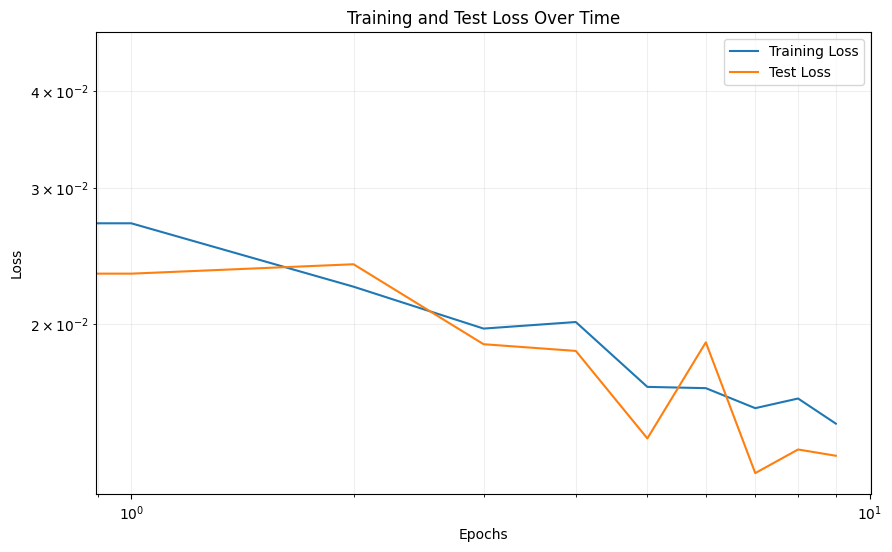

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


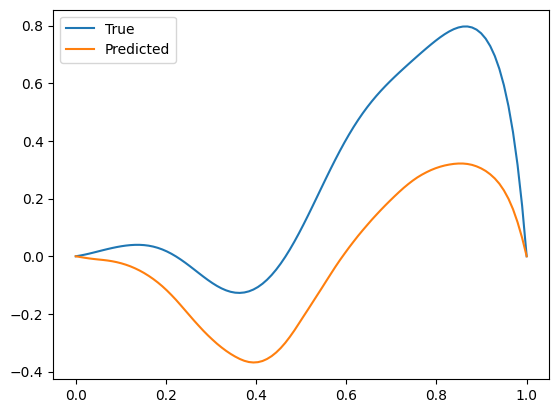

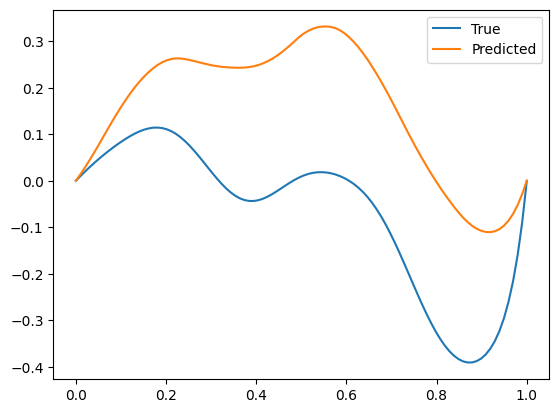

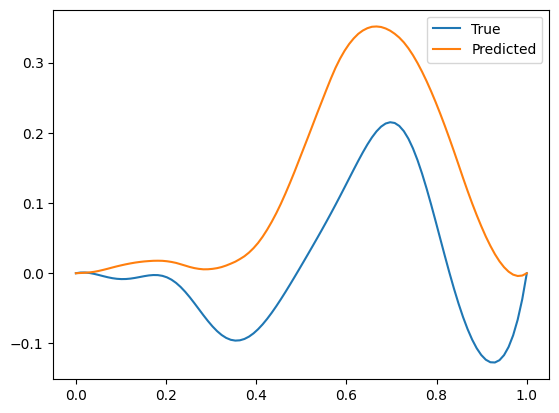

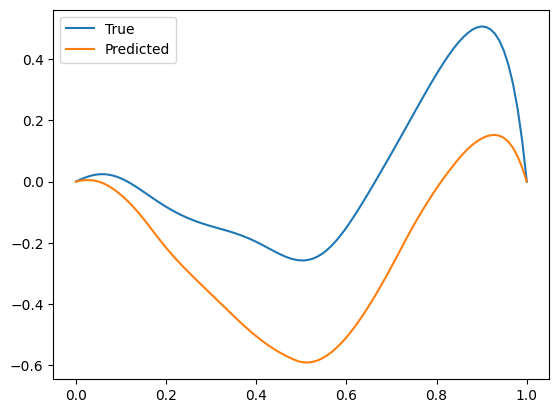

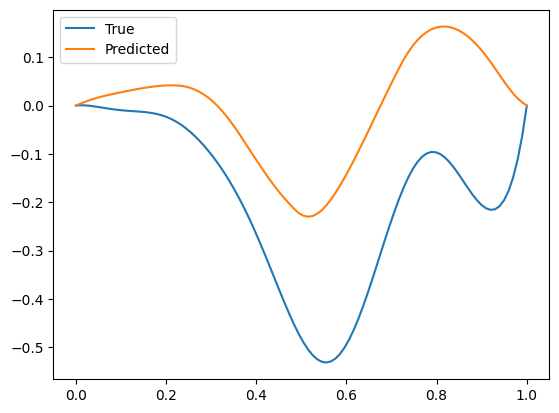

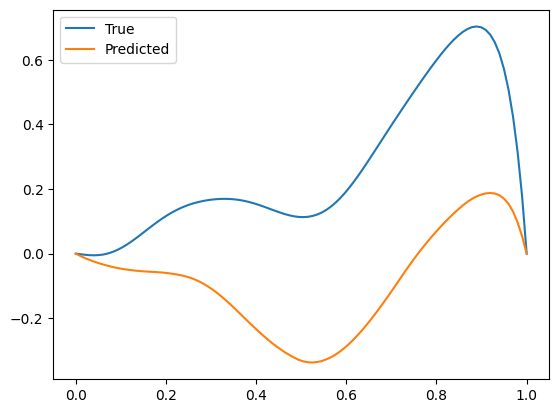

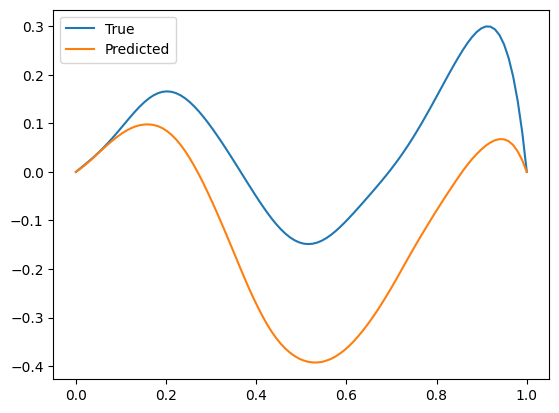

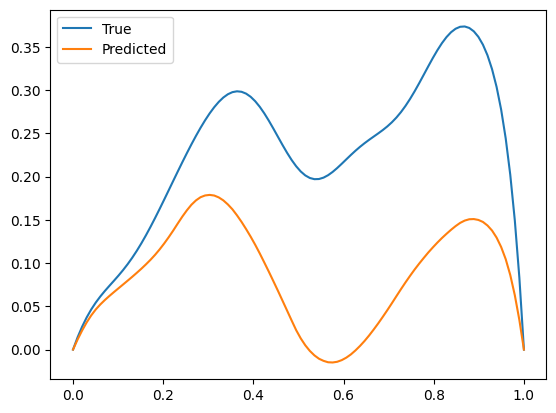

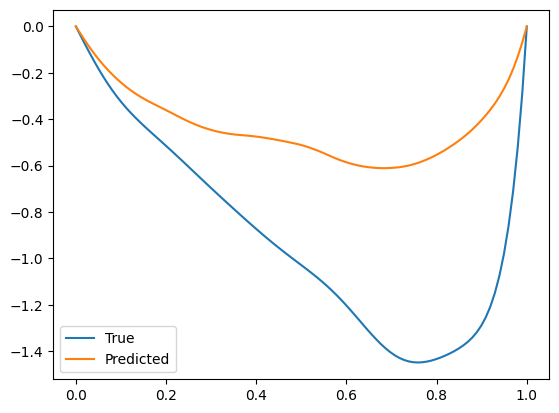

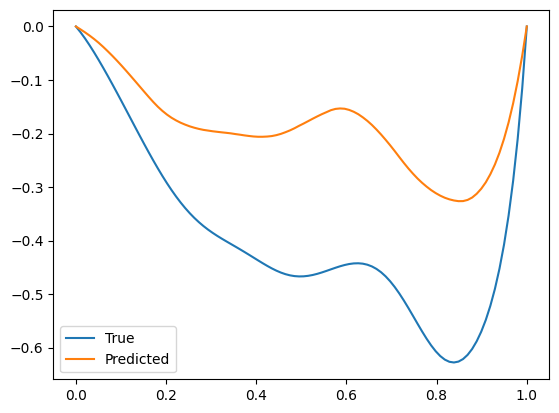

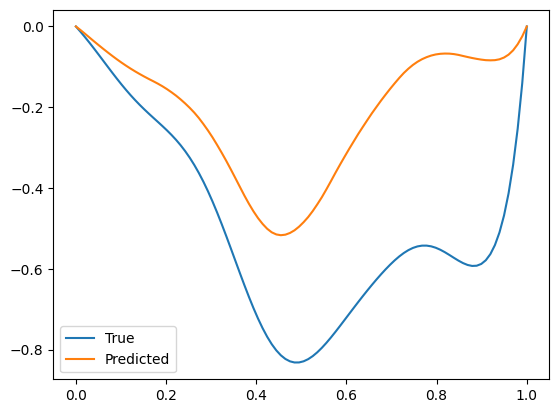

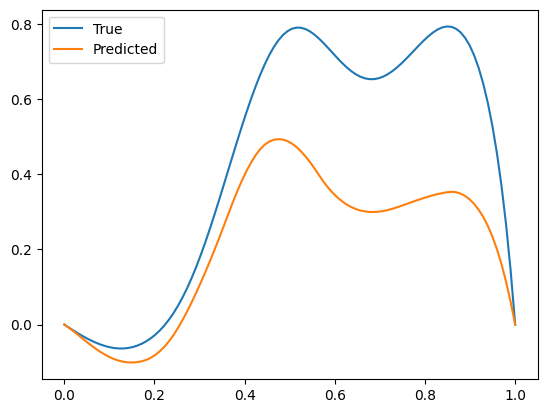

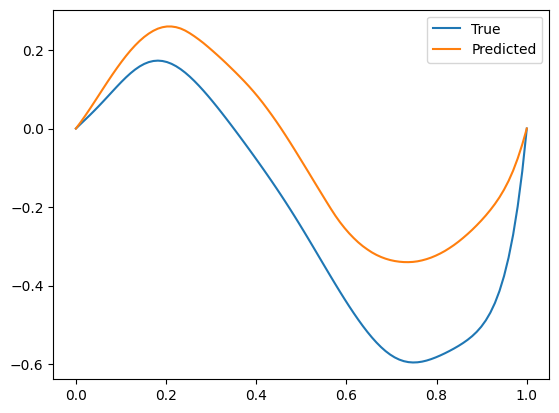

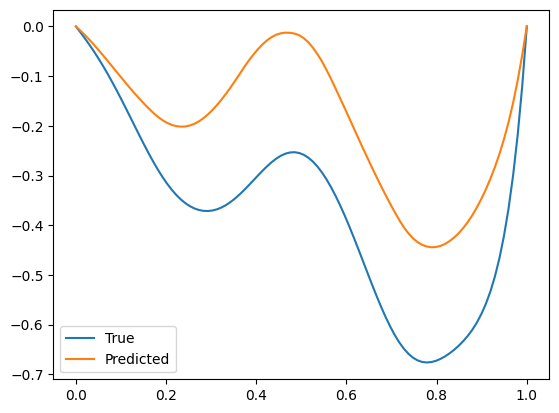

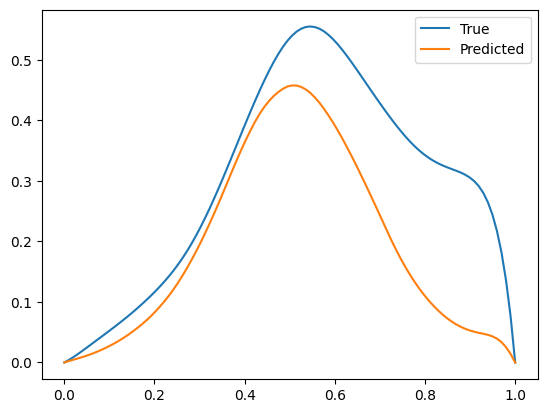

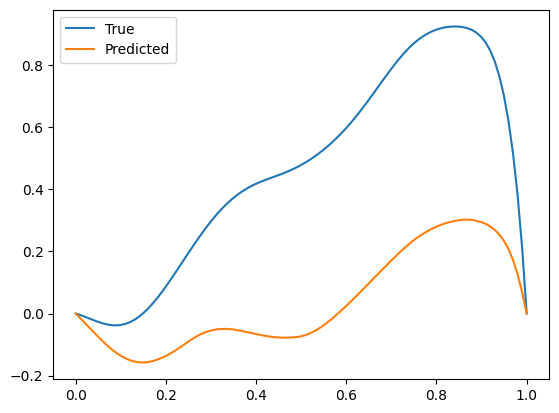

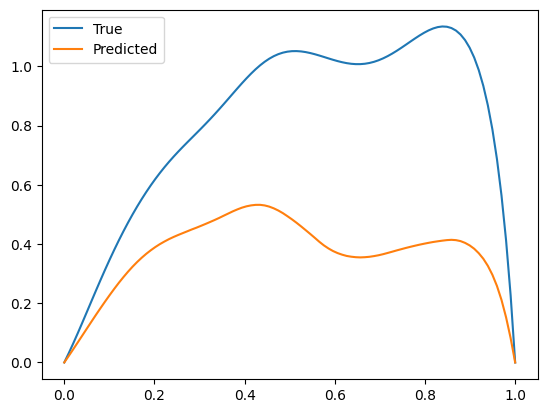

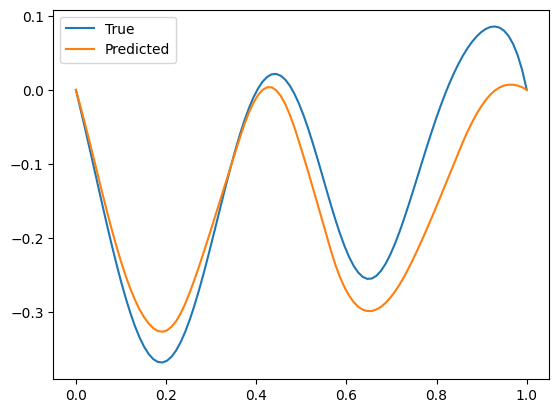

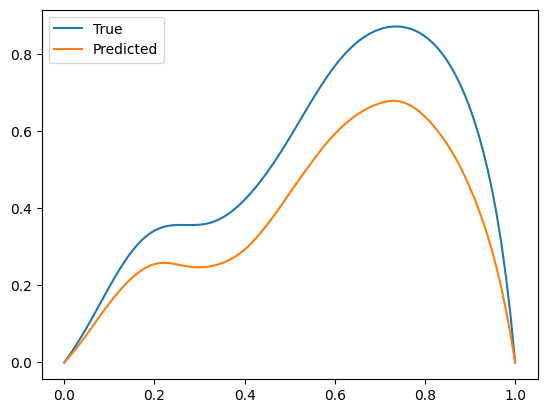

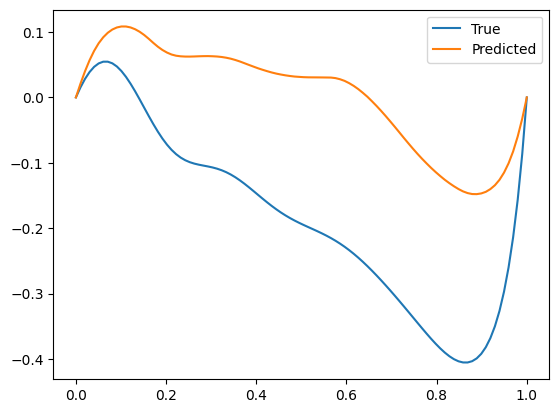

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:11:15,344 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:11:15,345 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.012353
2025-08-06 10:11:15,345 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.011963
Training progress:  10%|█         | 1/10 [00:04<00:41,  4.63s/it]2025-08-06 10:11:19,002 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:11:19,002 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.015533
2025-08-06 10:11:19,003 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.021504
Training progress:  20%|██        | 2/10 [00:08<00:32,  4.06s/it]2025-08-06 10:11:22,426 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:11:22,427 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.015188
2025-08-06 10:11:22,428 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.012057
Training progress:  30%|███       | 3/10 [00:11<00:26,  3.77s/i

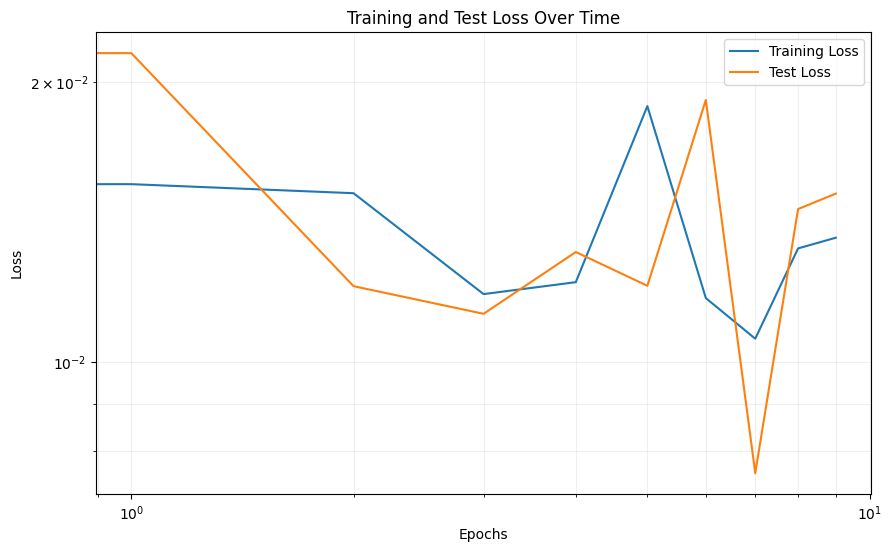

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


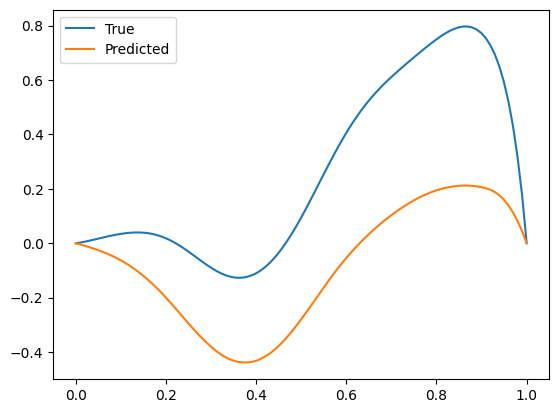

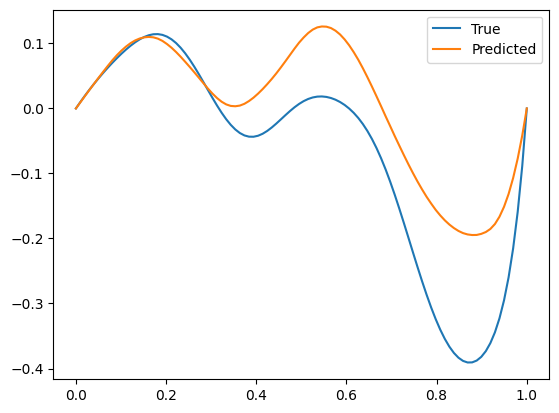

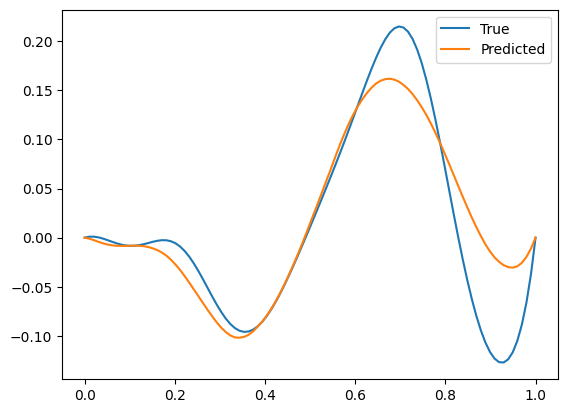

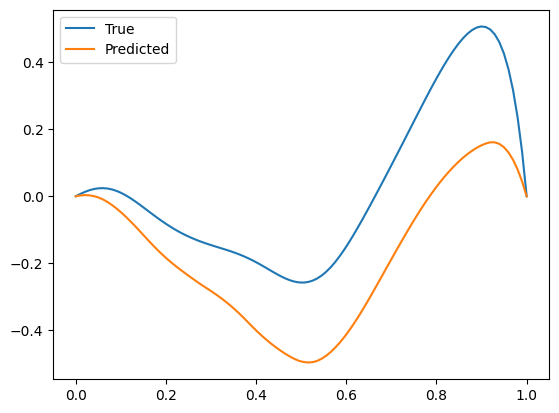

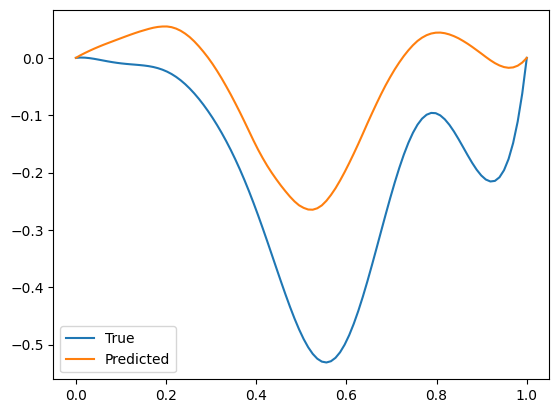

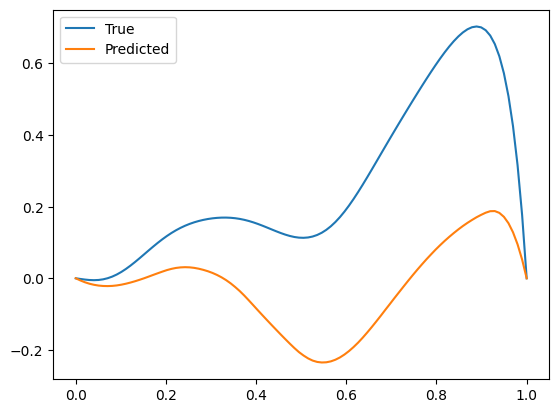

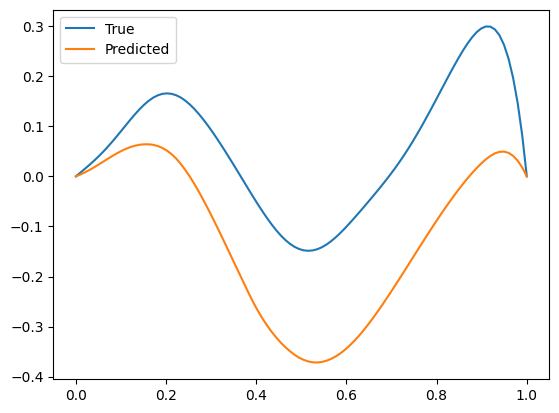

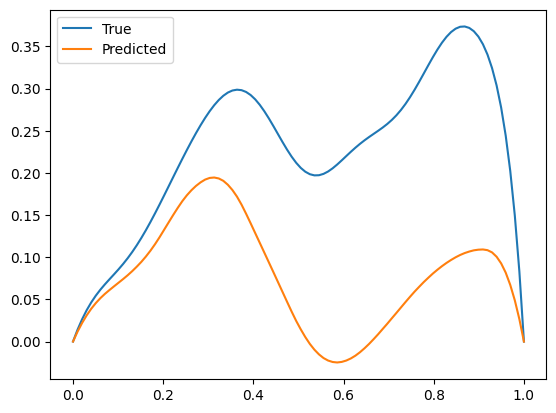

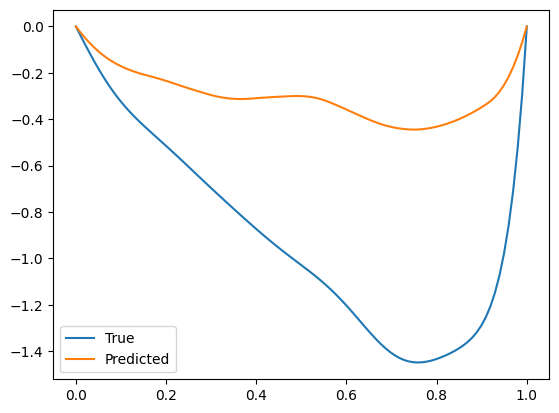

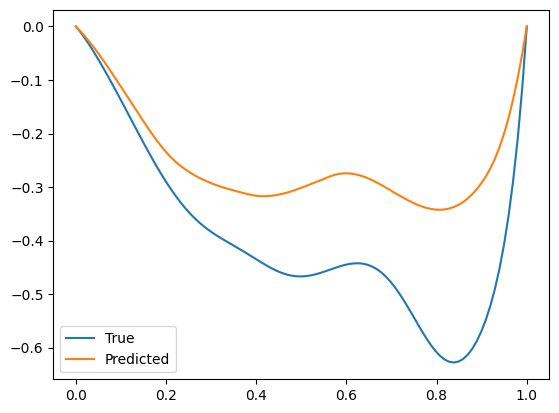

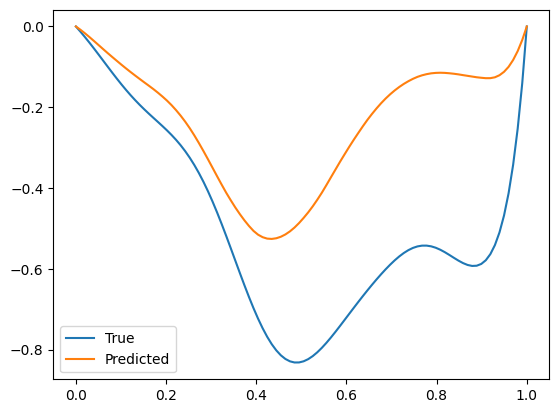

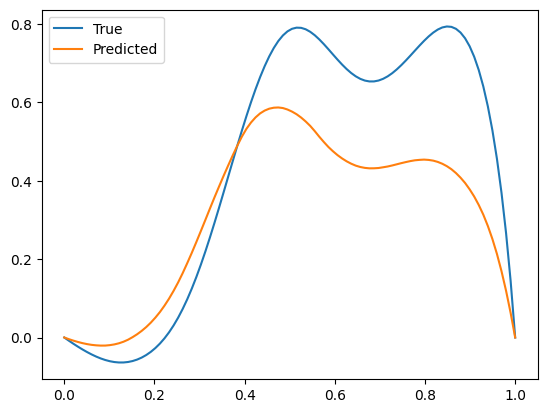

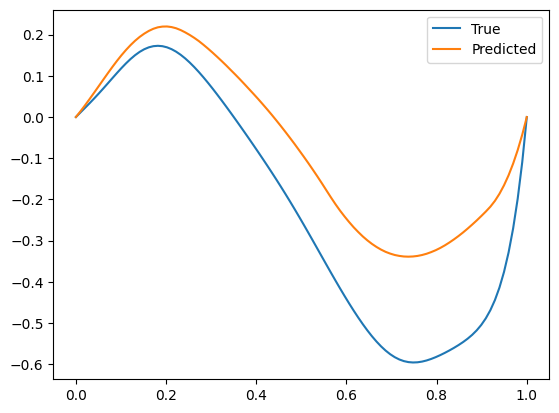

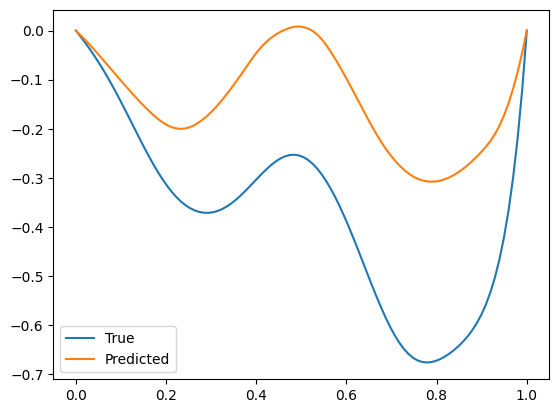

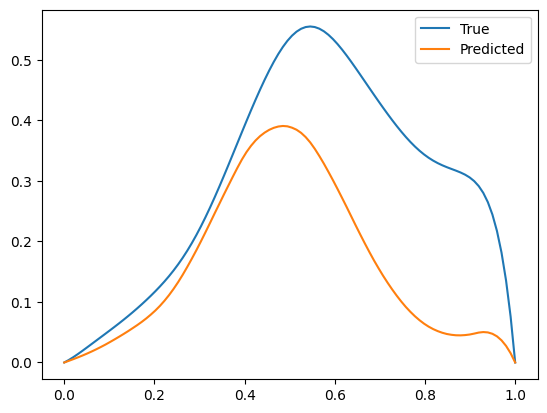

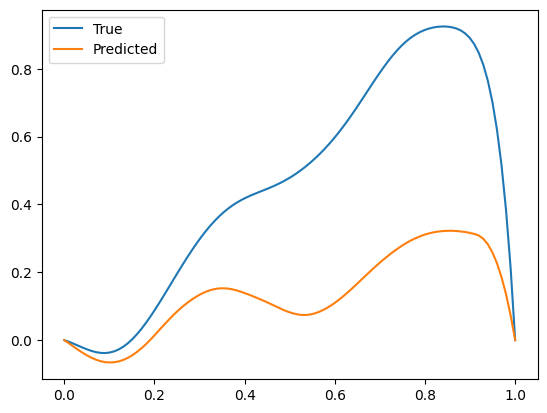

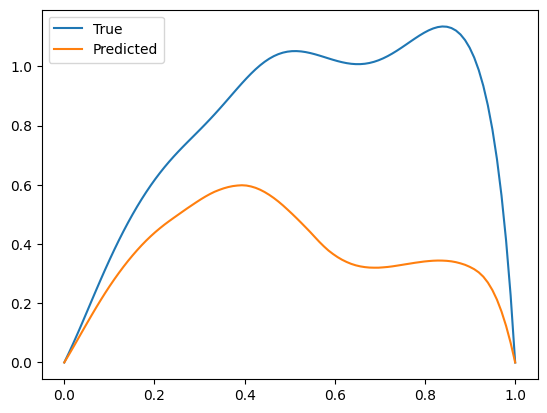

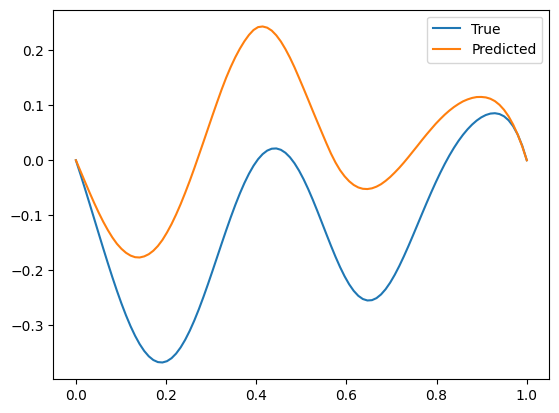

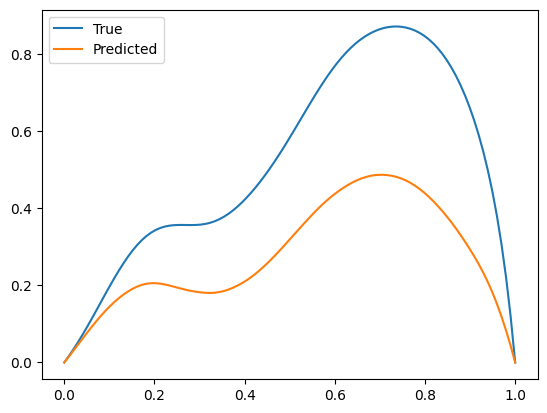

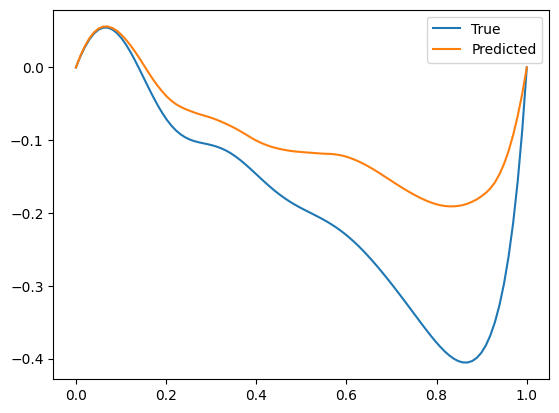

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:11:55,263 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:11:55,263 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.011265
2025-08-06 10:11:55,264 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.016351
Training progress:  10%|█         | 1/10 [00:04<00:41,  4.65s/it]2025-08-06 10:11:59,898 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:11:59,899 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.011266
2025-08-06 10:11:59,899 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.007014
Training progress:  20%|██        | 2/10 [00:09<00:37,  4.64s/it]2025-08-06 10:12:04,520 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:12:04,520 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.018247
2025-08-06 10:12:04,521 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.012356
Training progress:  30%|███       | 3/10 [00:13<00:32,  4.63s/i

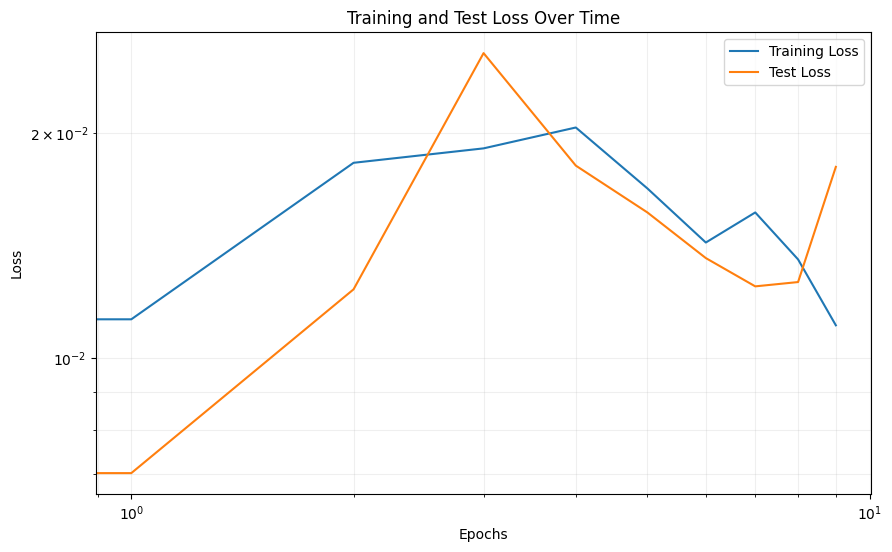

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


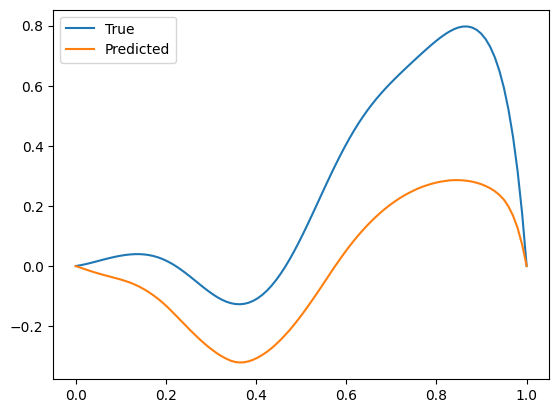

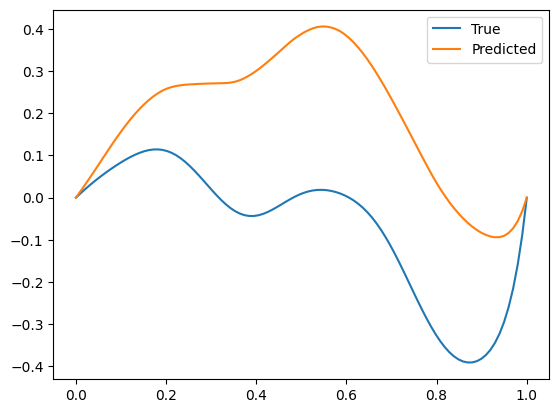

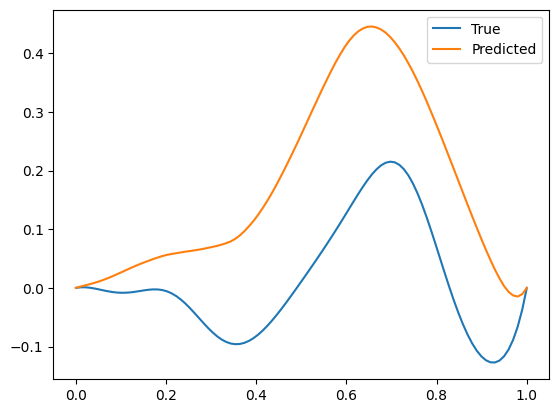

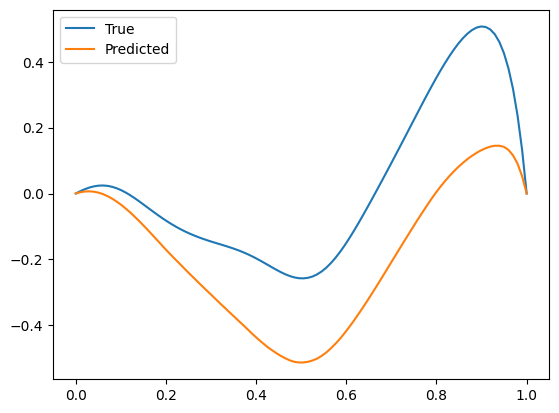

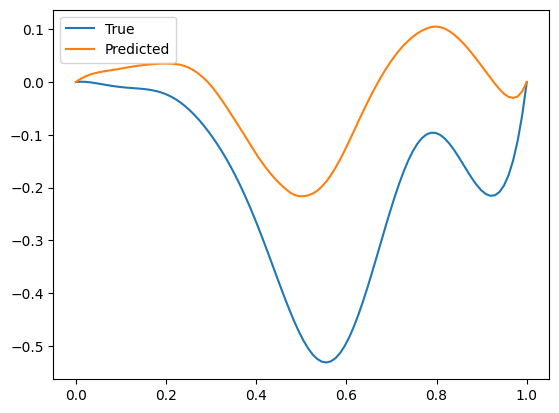

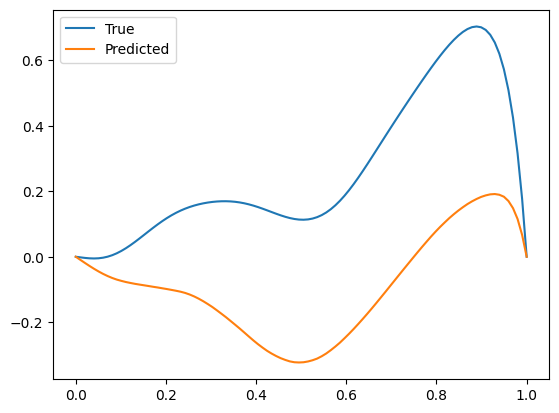

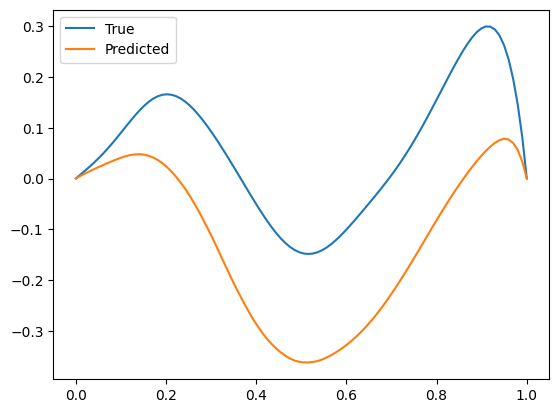

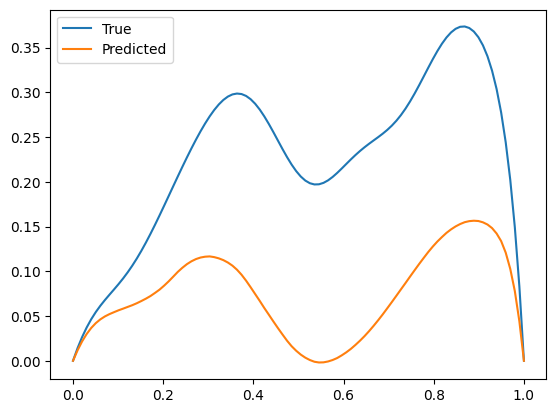

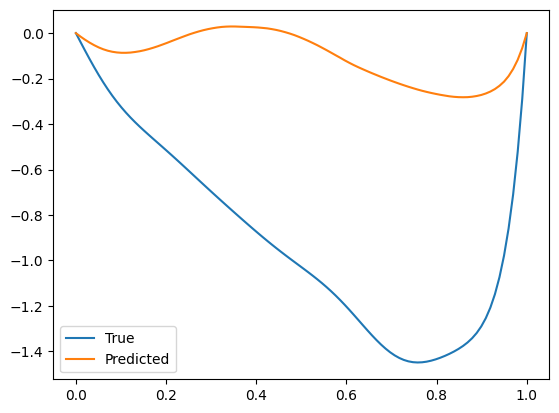

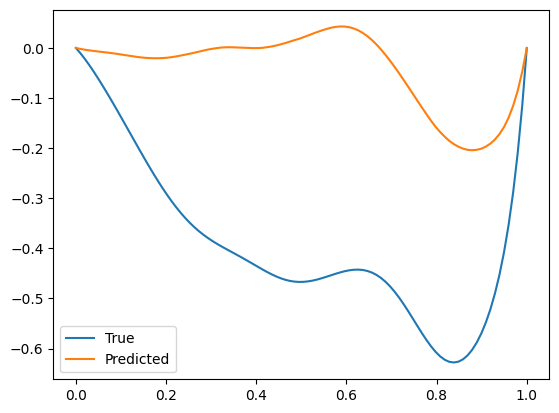

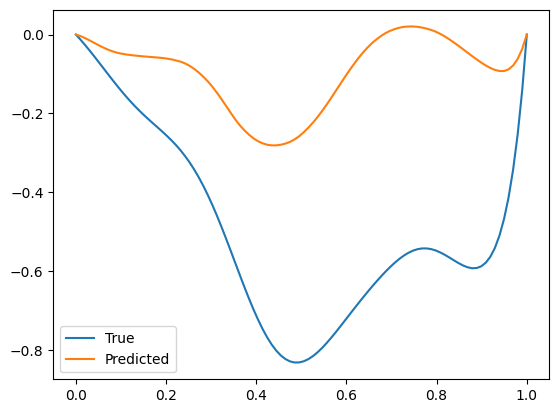

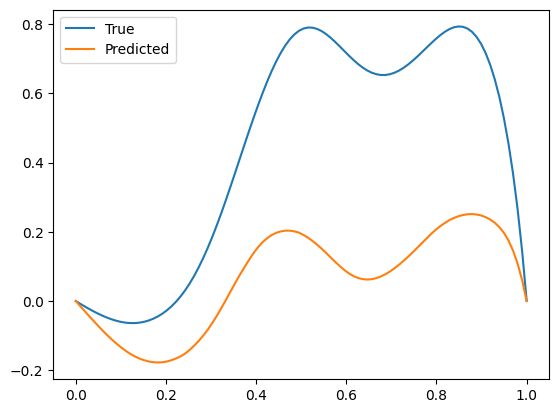

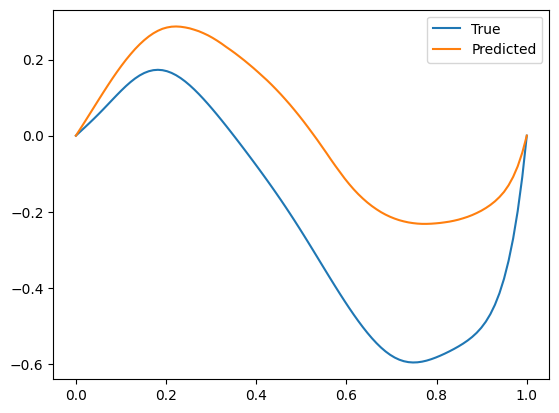

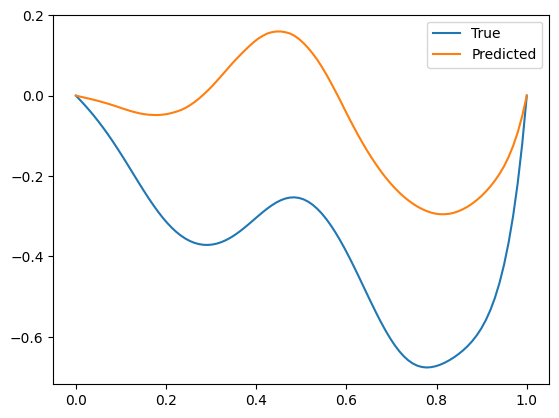

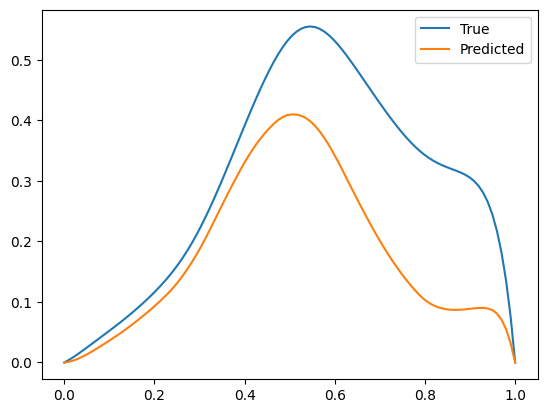

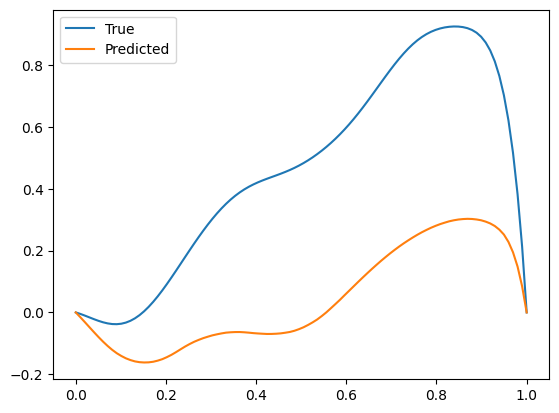

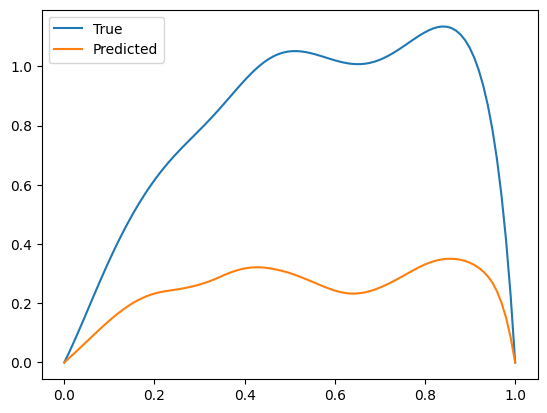

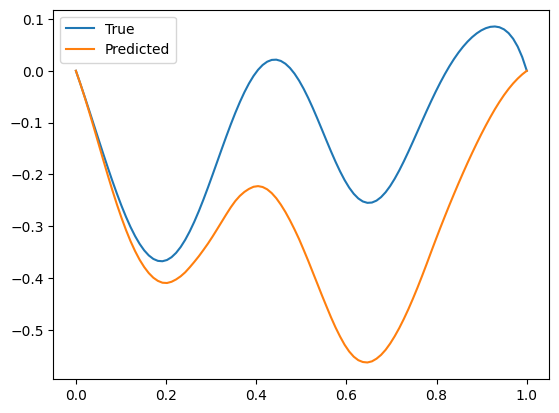

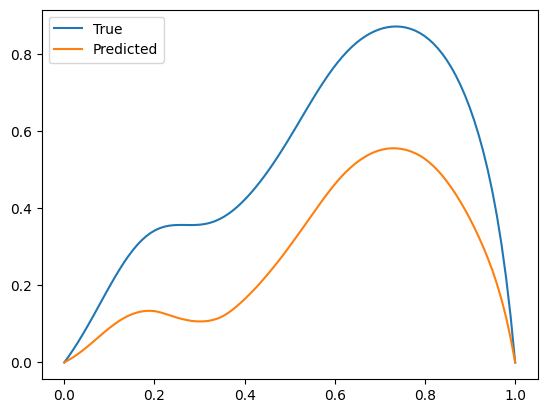

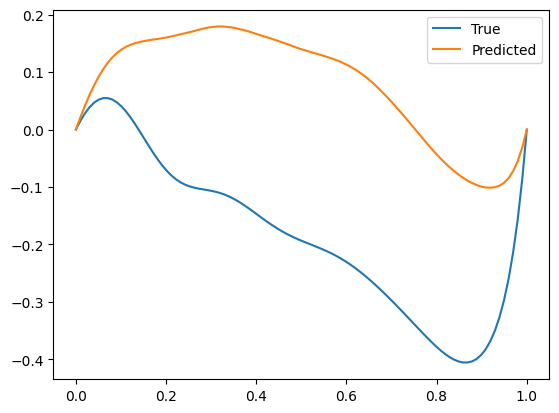

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


2025-08-06 10:12:35.546910: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:12:40,224 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:12:40,225 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.012314
2025-08-06 10:12:40,225 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.010098
Training progress:  10%|█         | 1/10 [00:04<00:41,  4.65s/it]2025-08-06 10:12:47,553 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:12:47,553 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.013579
2025-08-06 10:12:47,554 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.007959
Training progress:  20%|██        | 2/10 [00:11<00:49,  6.23s/it]2025-08-06 10:12:52,175 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:12:52,175 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.01

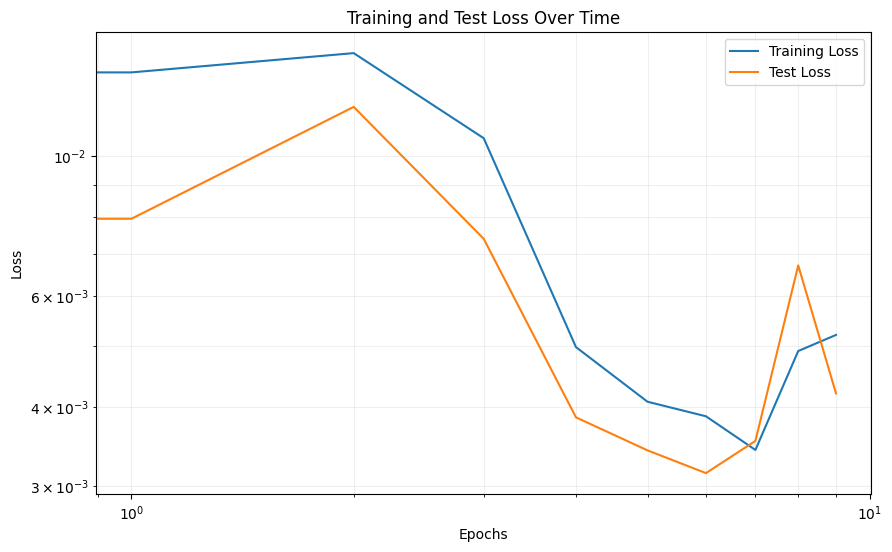

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


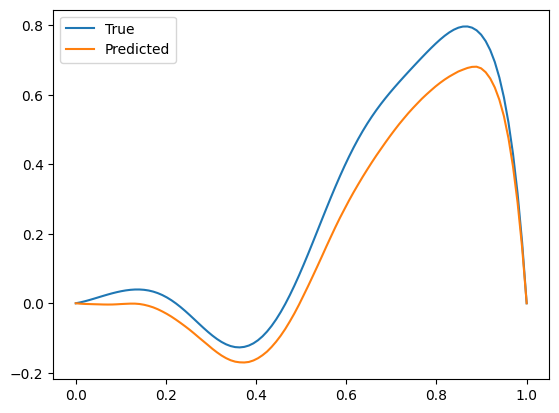

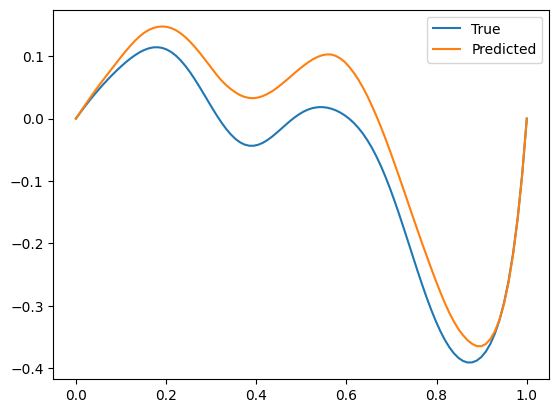

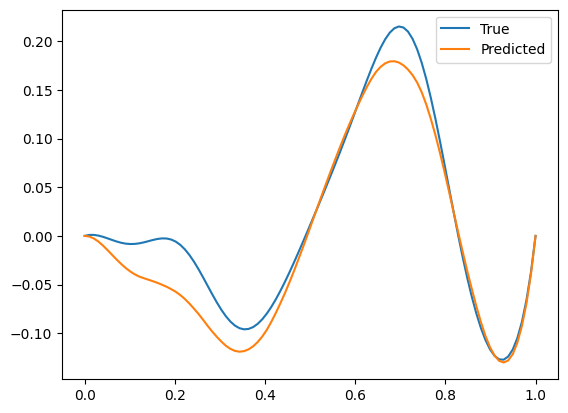

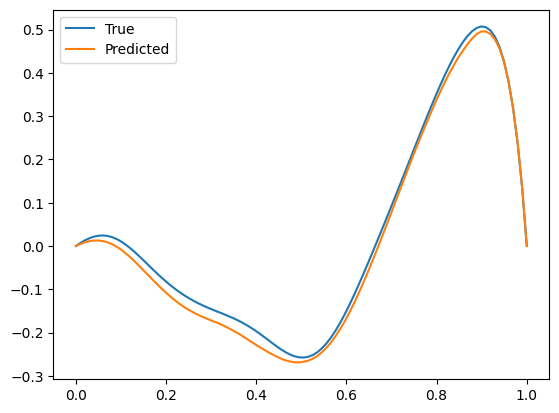

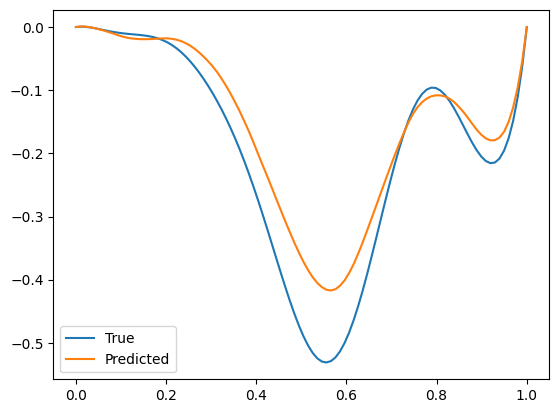

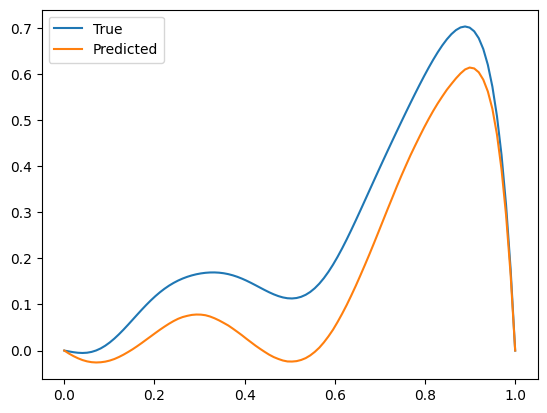

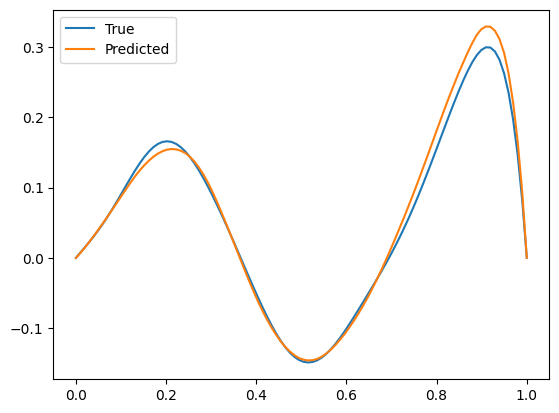

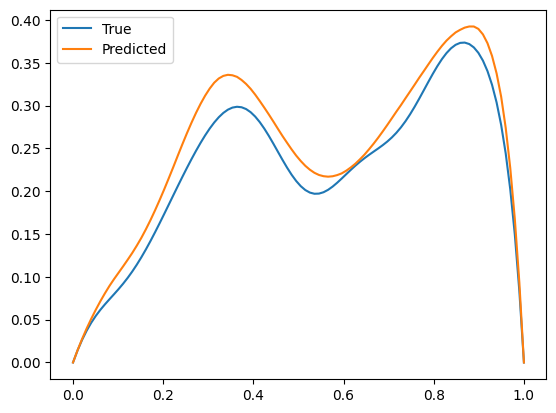

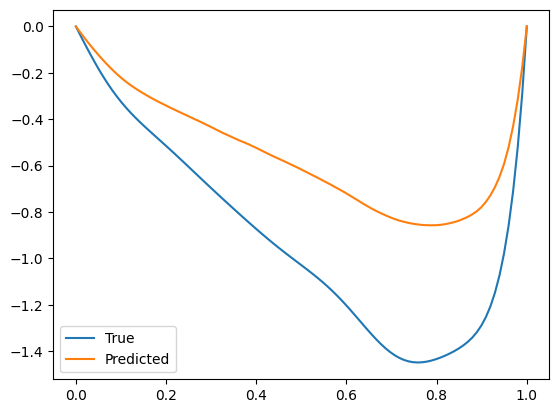

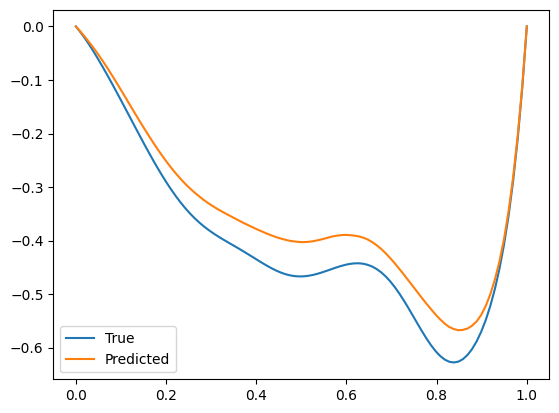

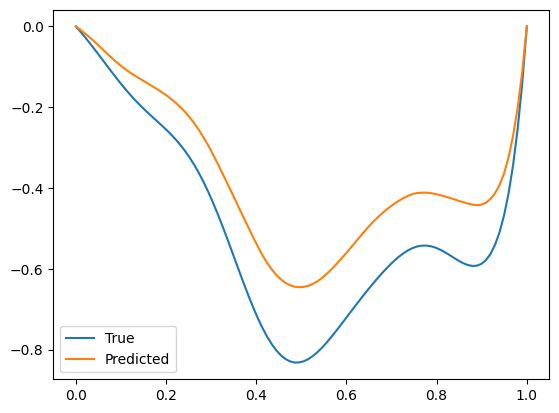

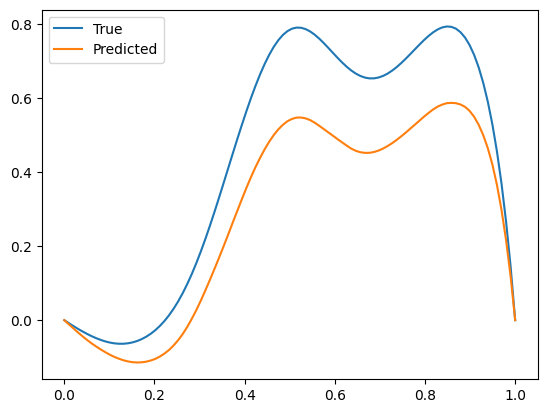

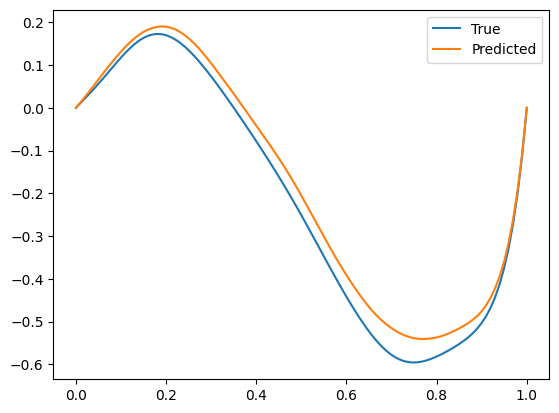

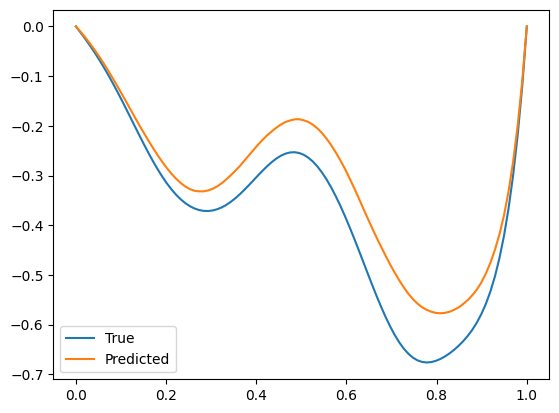

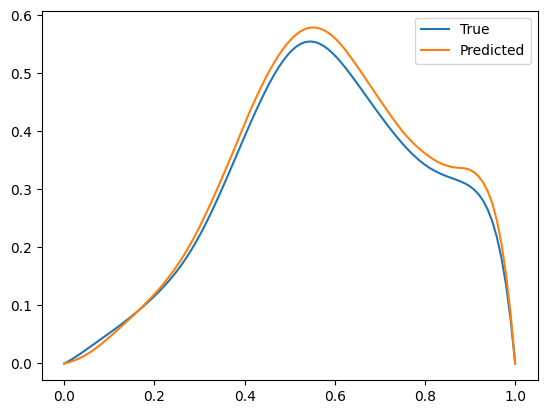

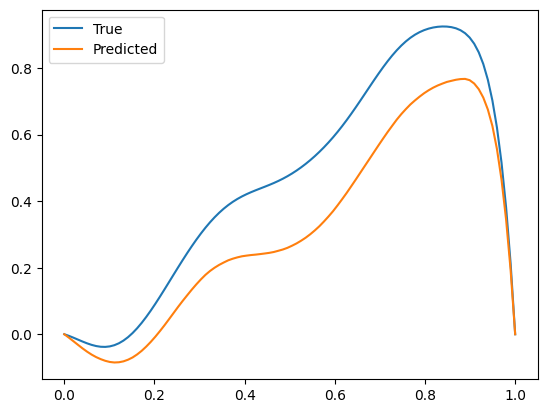

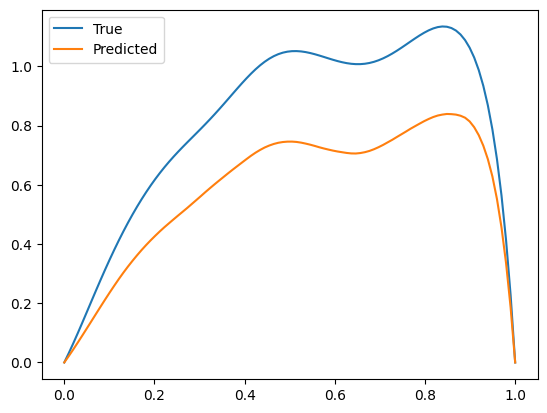

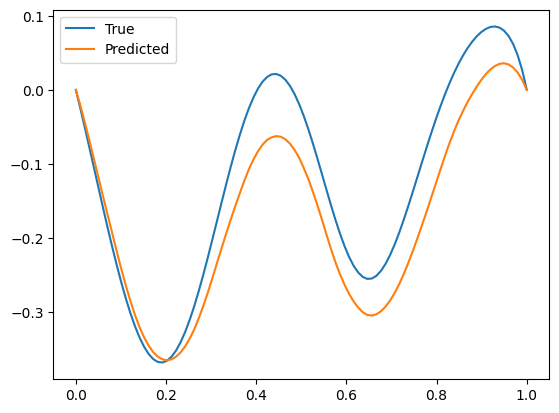

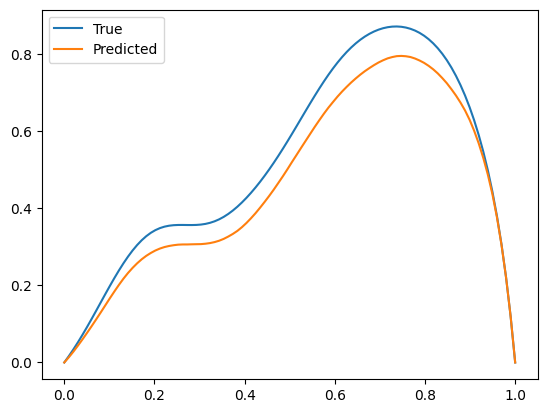

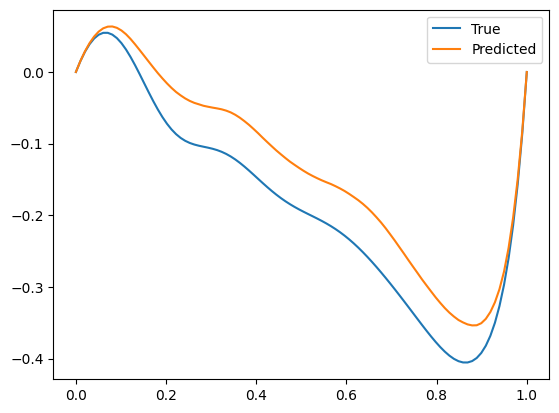

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:13:29,696 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:13:29,697 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.003653
2025-08-06 10:13:29,697 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.002903
Training progress:  10%|█         | 1/10 [00:04<00:42,  4.70s/it]2025-08-06 10:13:34,298 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:13:34,299 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.002952
2025-08-06 10:13:34,300 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.002477
Training progress:  20%|██        | 2/10 [00:09<00:37,  4.64s/it]2025-08-06 10:13:38,828 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:13:38,828 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.002832
2025-08-06 10:13:38,829 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003711
Training progress:  30%|███       | 3/10 [00:13<00:32,  4.59s/i

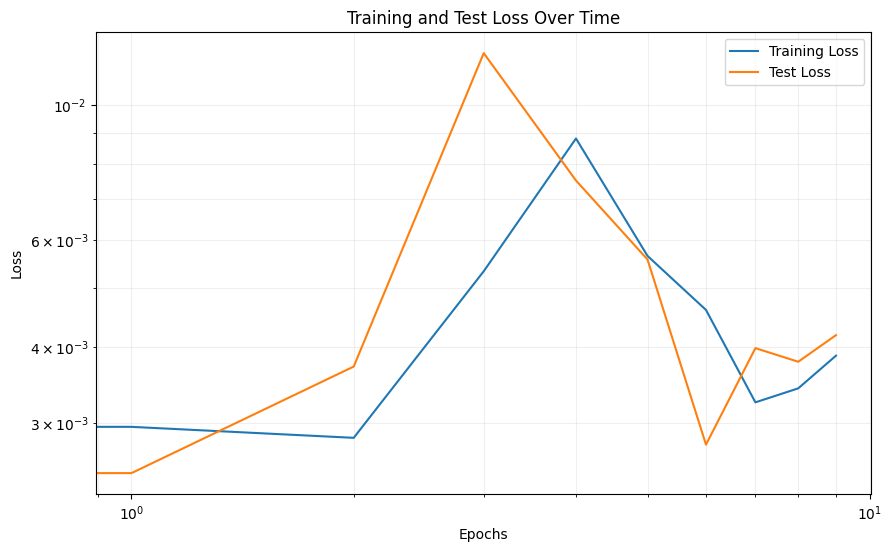

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


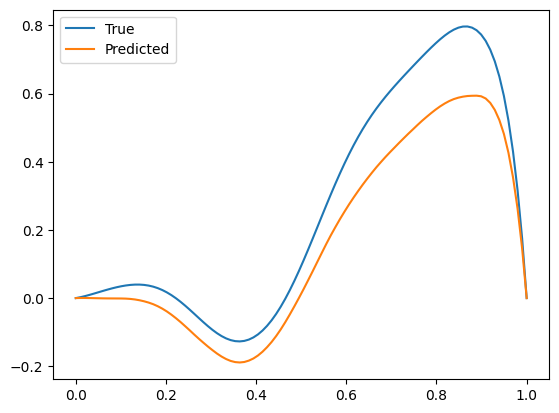

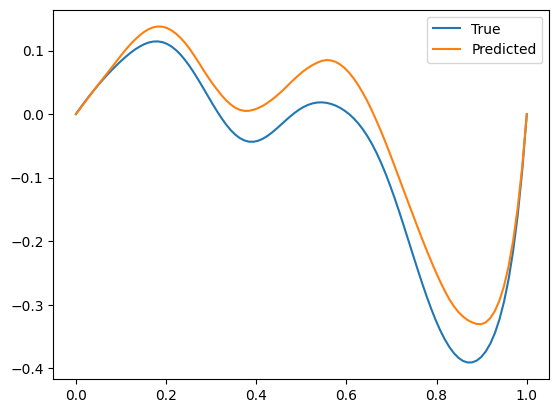

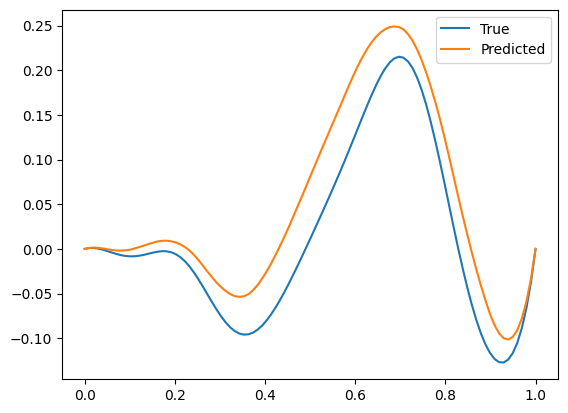

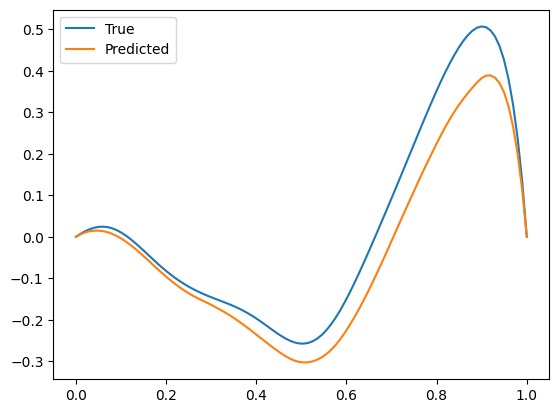

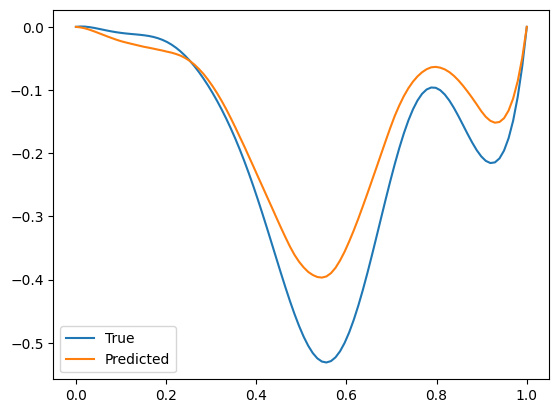

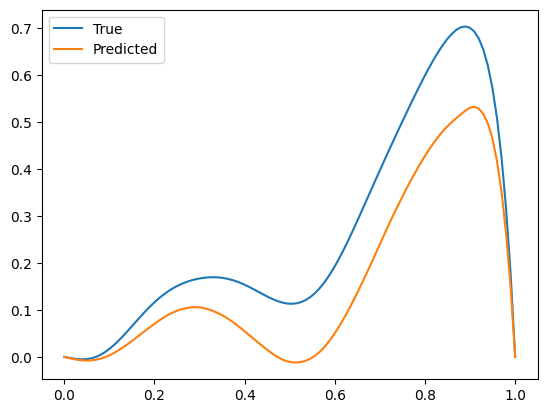

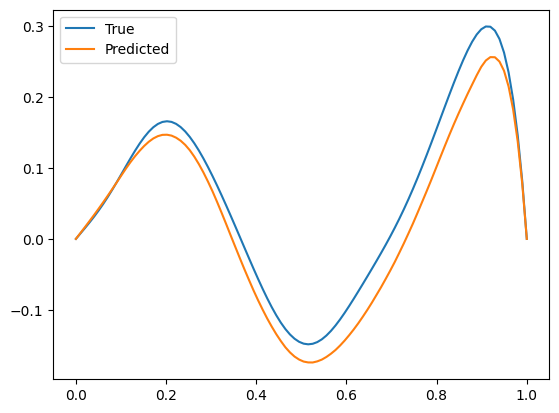

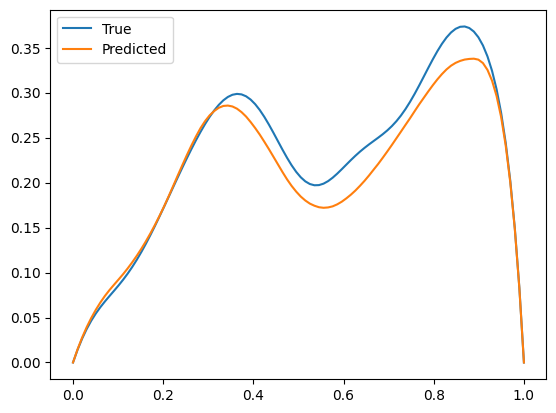

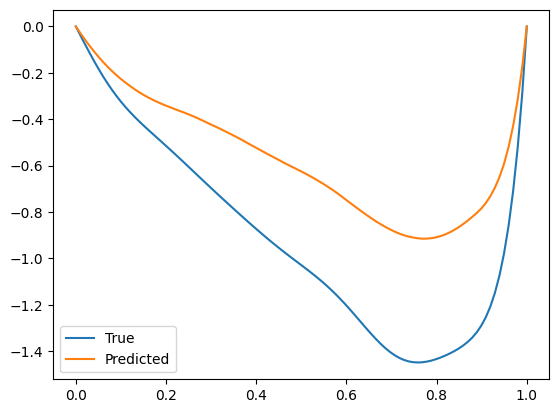

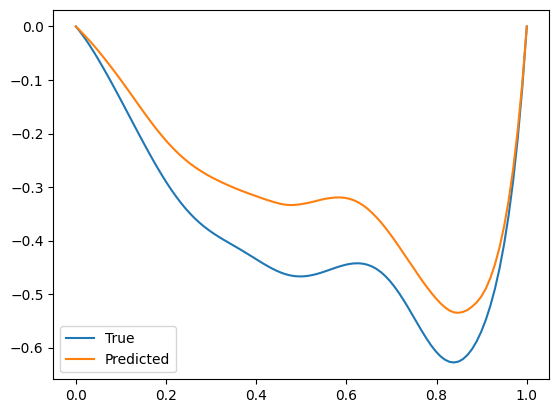

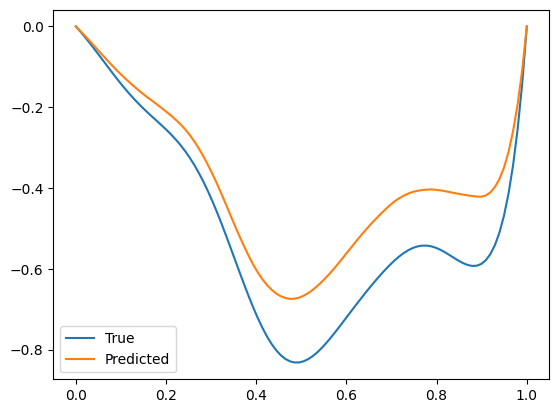

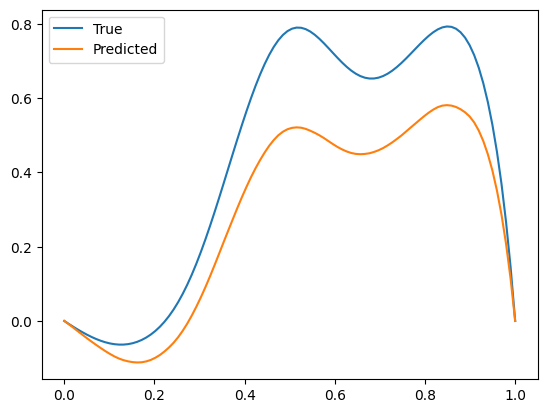

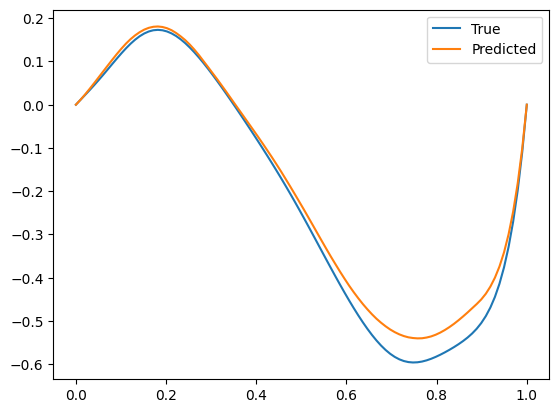

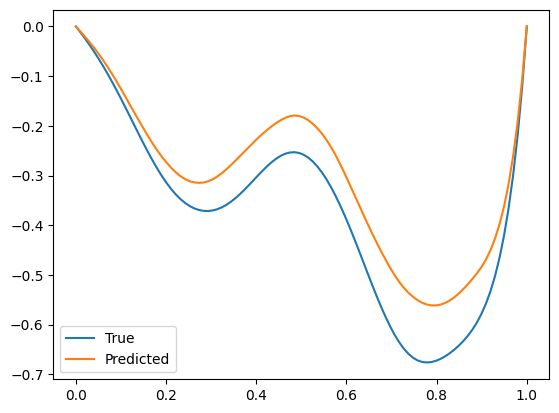

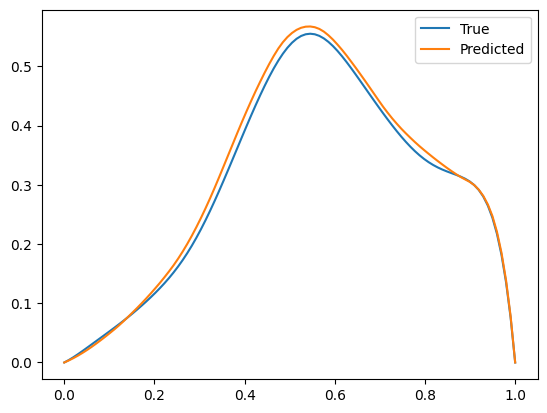

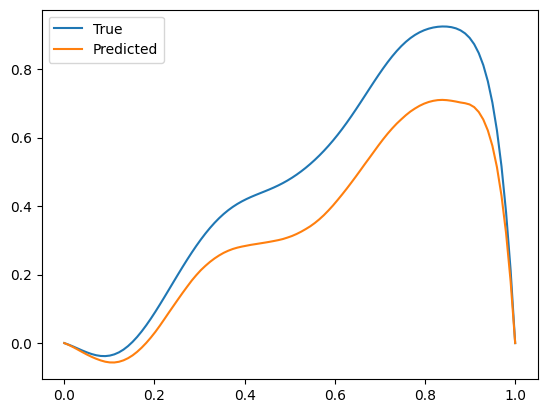

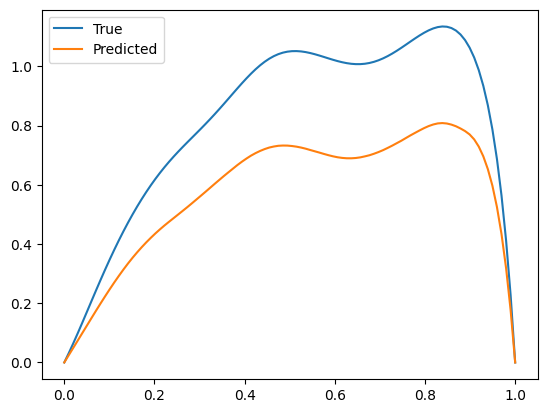

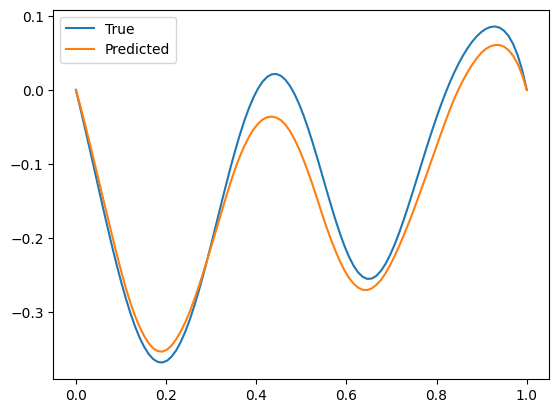

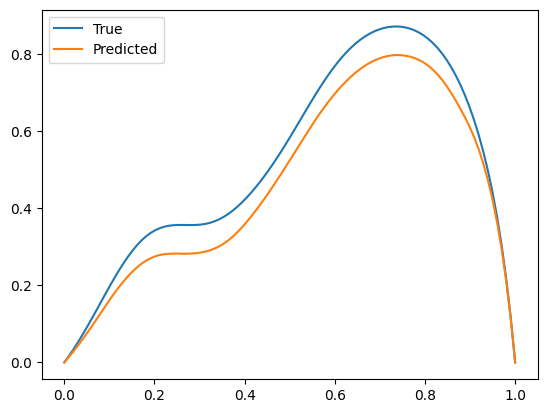

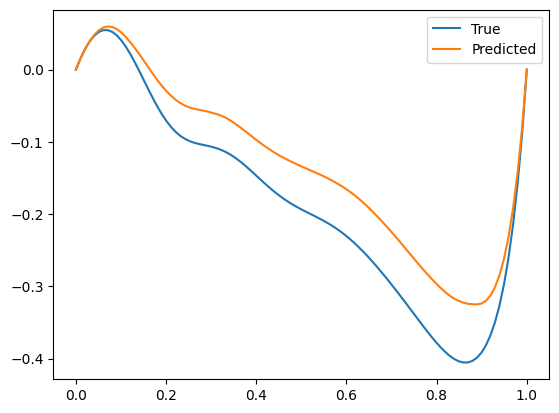

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:14:11,500 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:14:11,501 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.008880
2025-08-06 10:14:11,502 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.005776
Training progress:  10%|█         | 1/10 [00:04<00:39,  4.44s/it]2025-08-06 10:14:14,550 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:14:14,551 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.011162
2025-08-06 10:14:14,551 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.019896
Training progress:  20%|██        | 2/10 [00:07<00:28,  3.62s/it]2025-08-06 10:14:17,836 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:14:17,837 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.014070
2025-08-06 10:14:17,837 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.008464
Training progress:  30%|███       | 3/10 [00:10<00:24,  3.47s/i

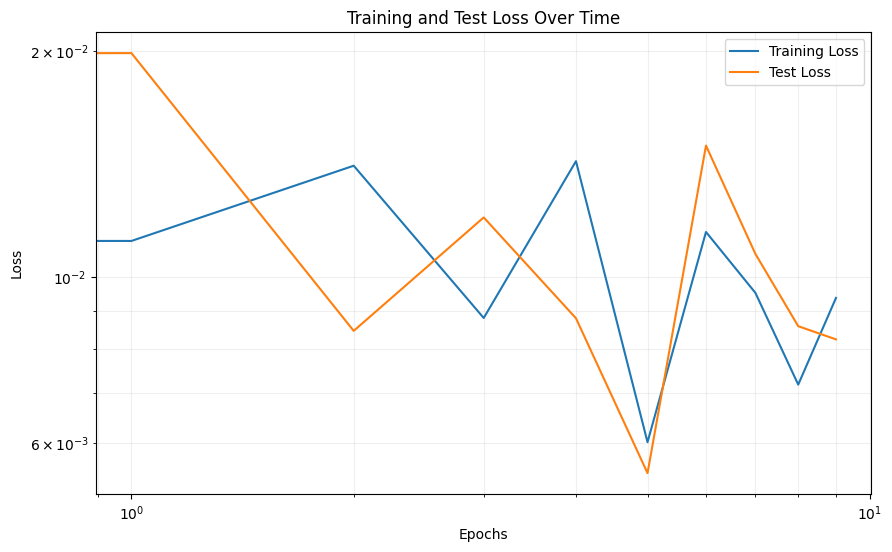

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


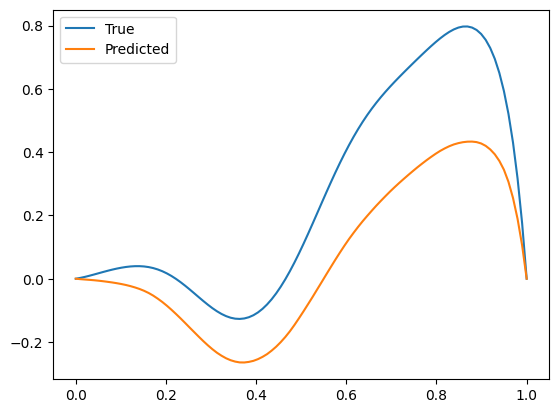

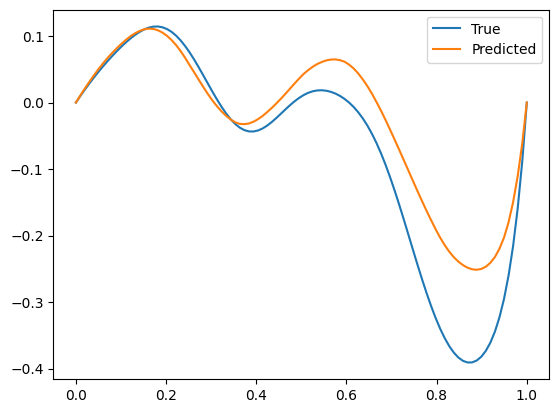

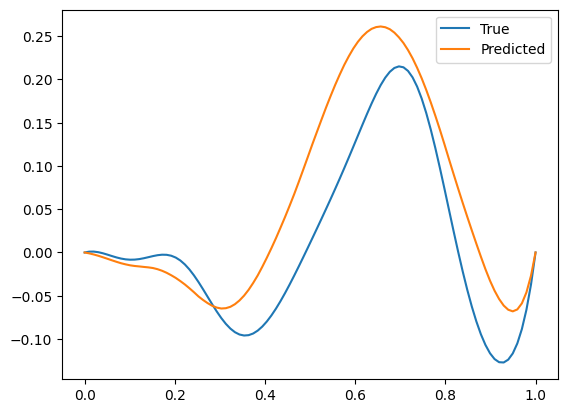

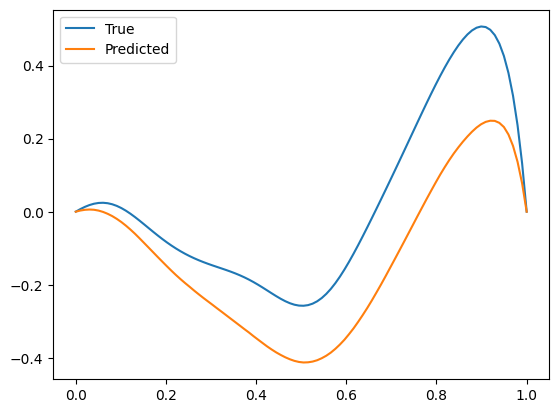

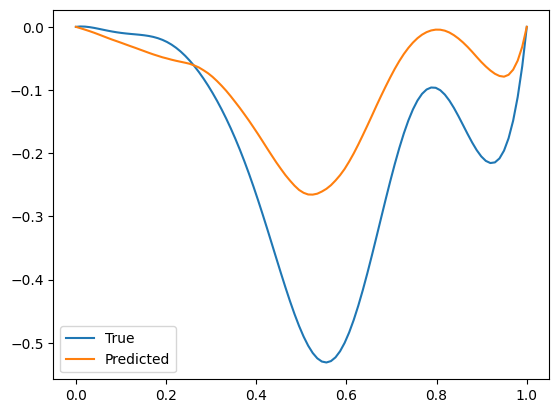

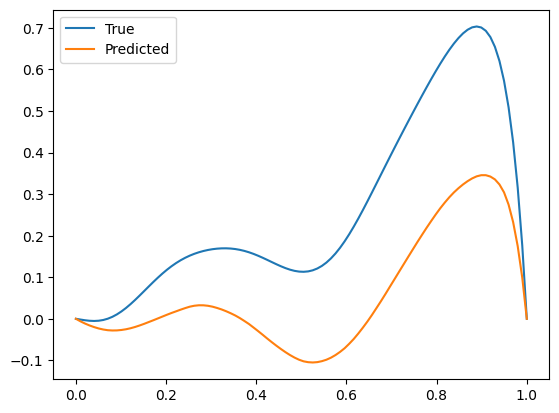

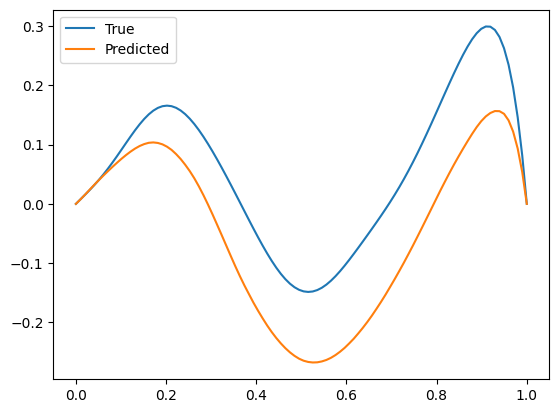

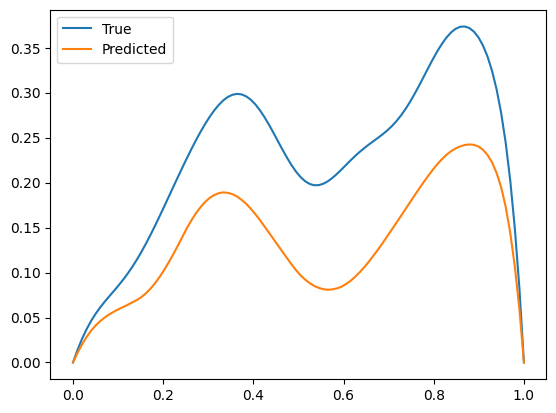

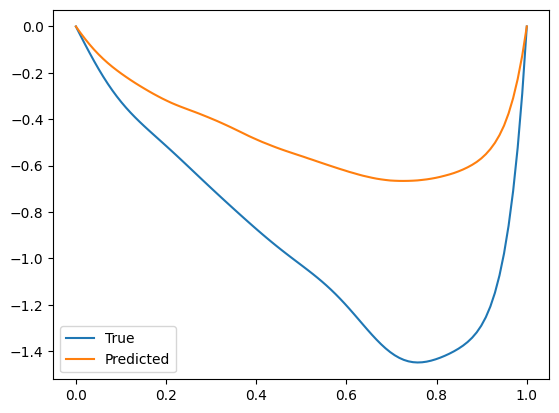

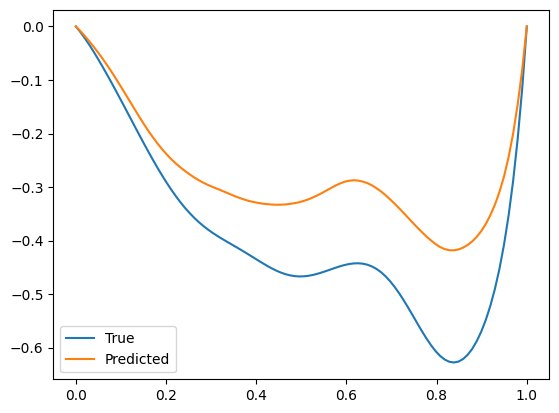

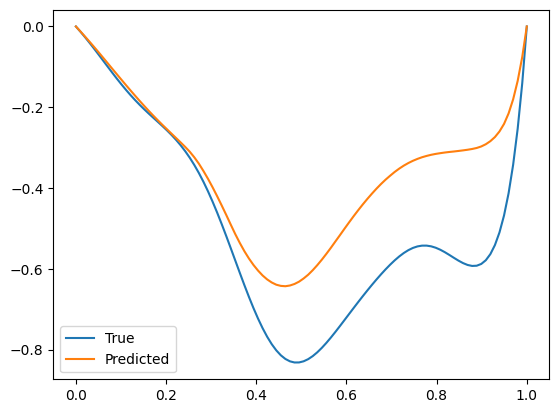

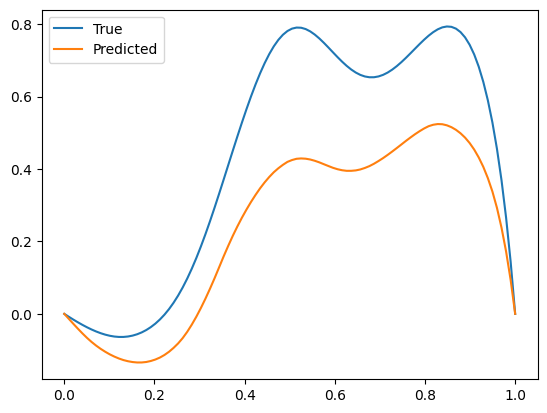

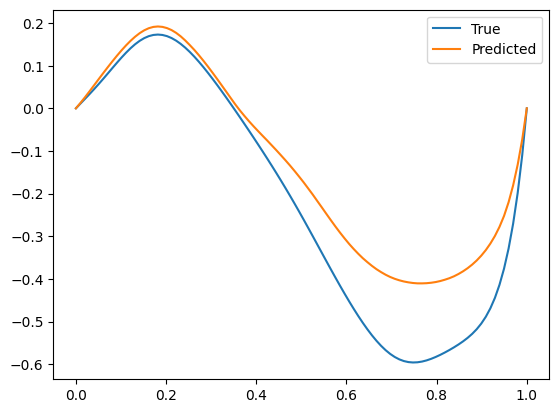

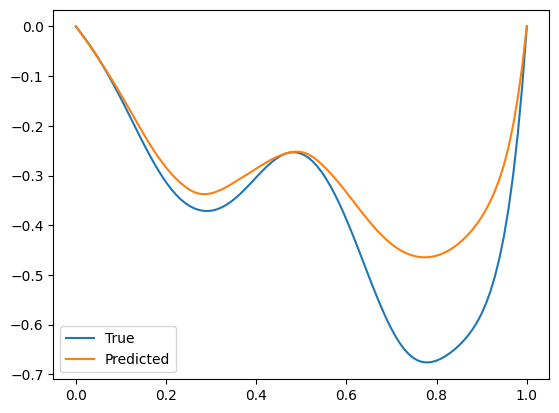

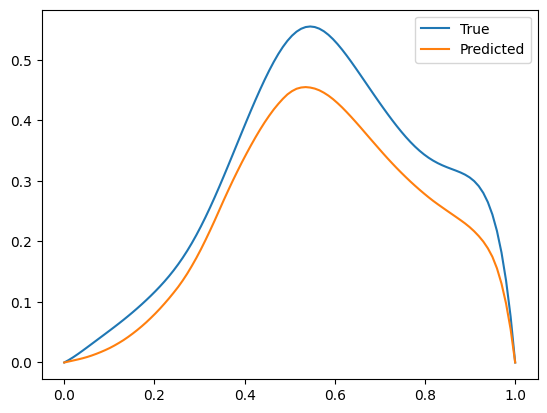

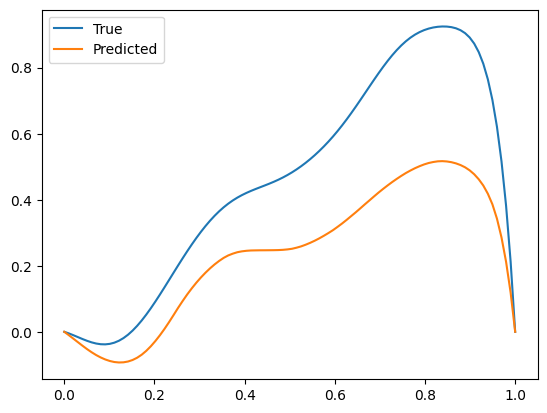

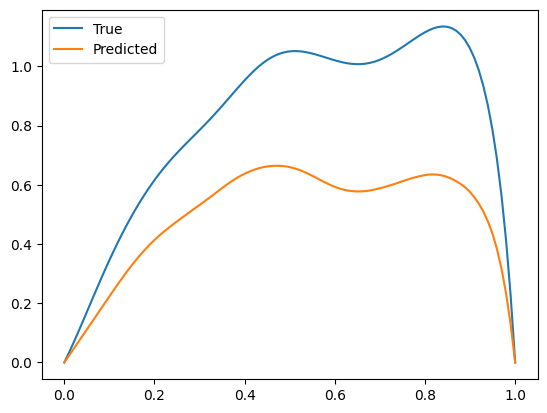

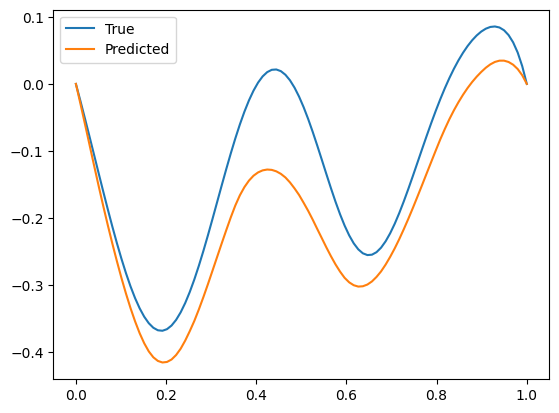

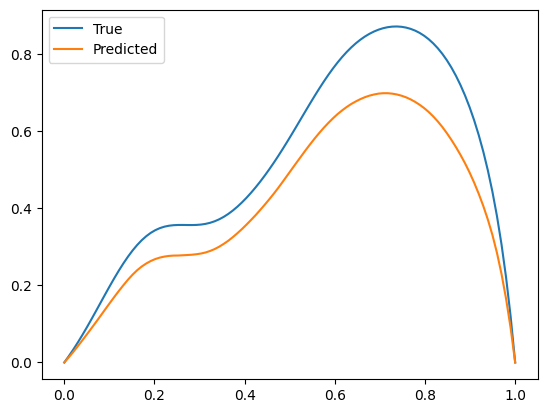

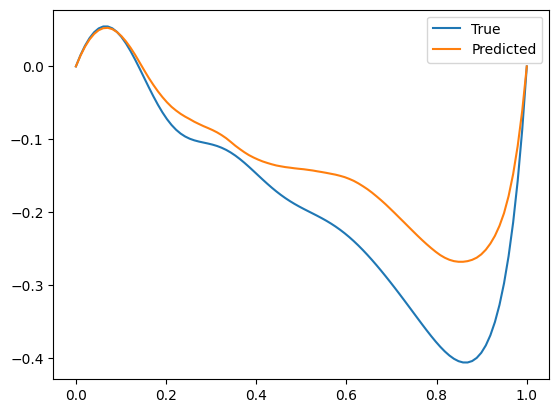

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:14:50.495391: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-06 10:14:50,710 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:14:50,711 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.007201
2025-08-06 10:14:50,712 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.010296
Training progress:  10%|█         | 1/10 [00:04<00:41,  4.60s/it]2025-08-06 10:14:55,388 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:14:55,389 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.008426
2025-08-06 10:14:55,390 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.006847
Training progress:  20%|██        | 2/10 [00:09<00:37,  4.65s/it]2025-08-06 10:14:59,569 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:14:59,570 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.01

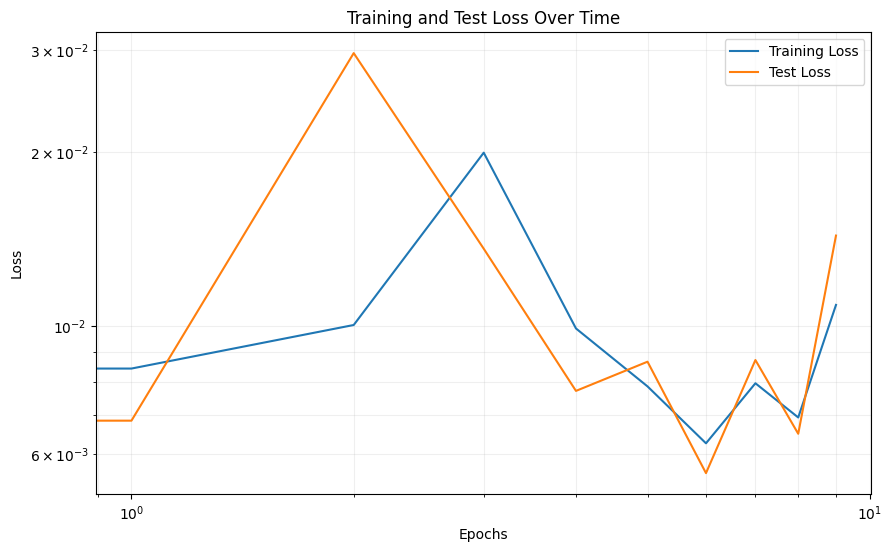

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


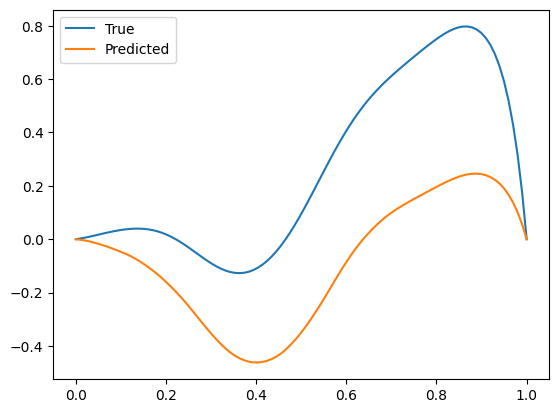

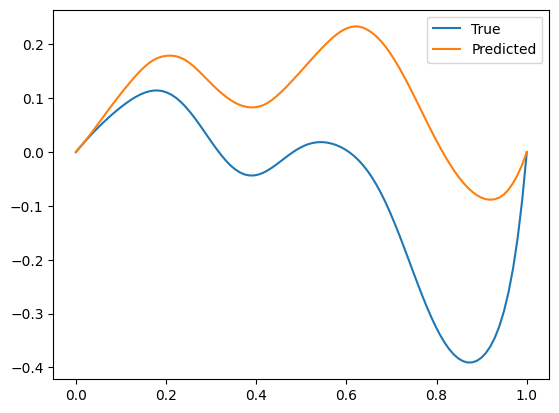

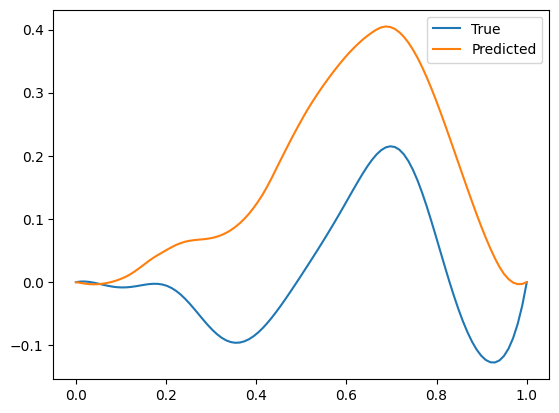

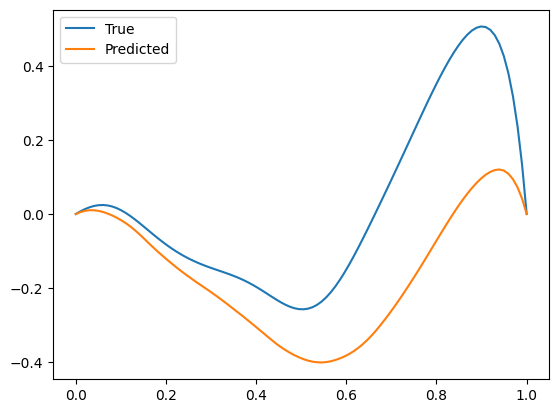

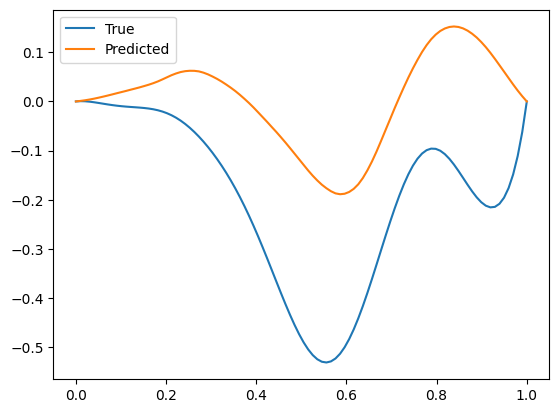

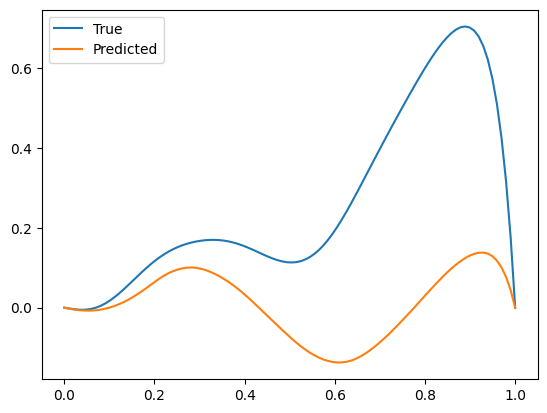

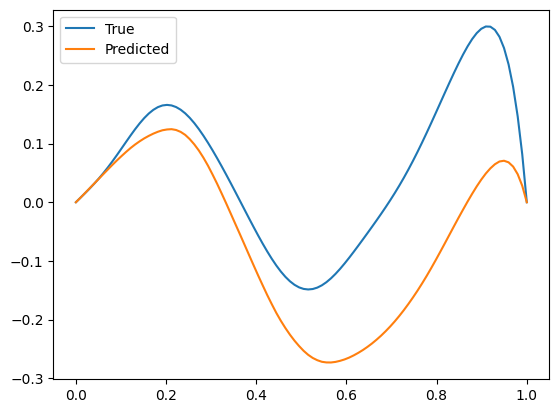

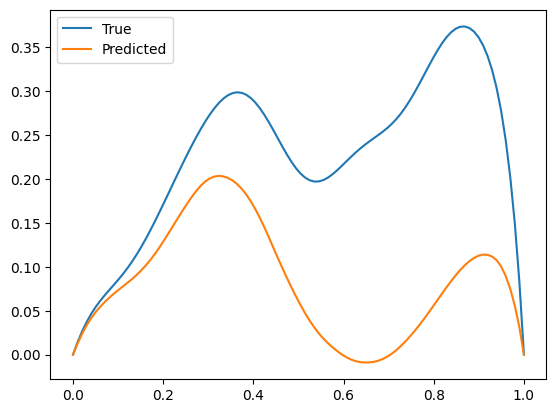

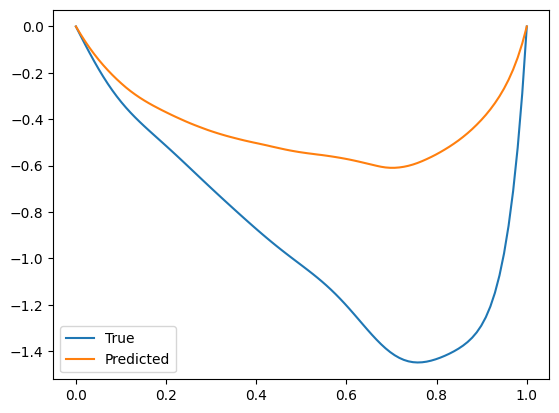

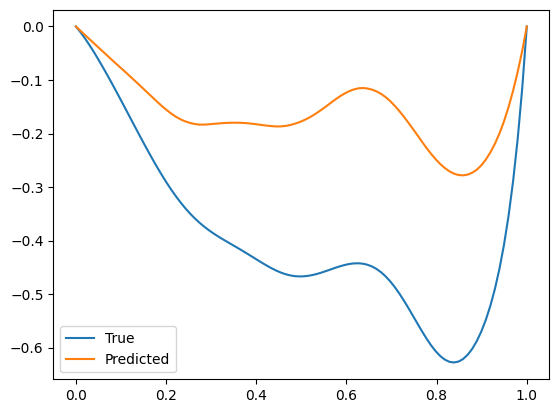

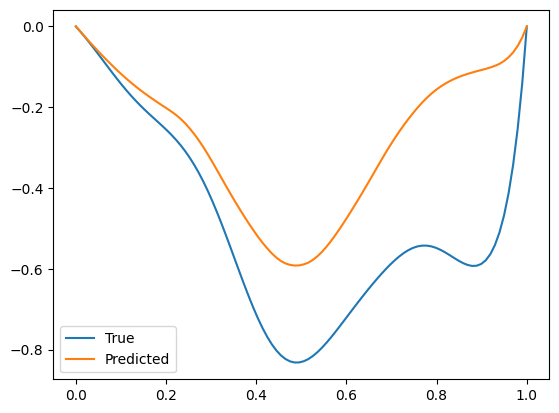

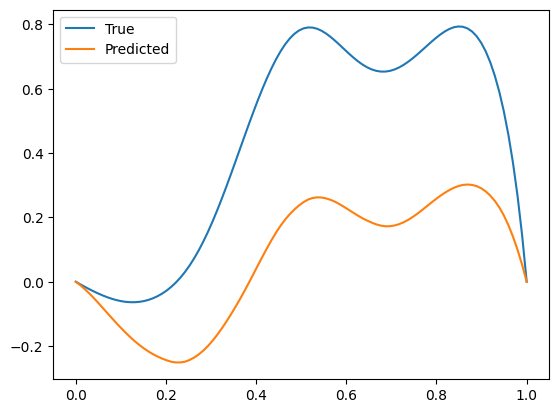

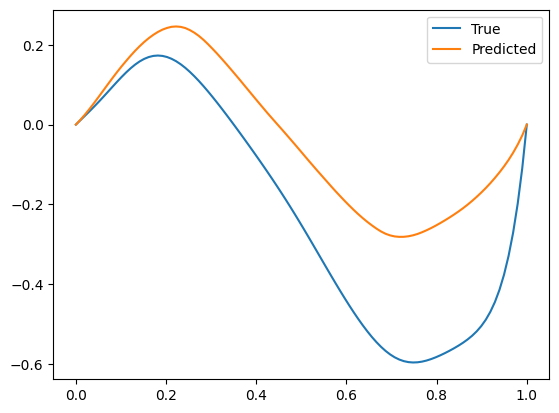

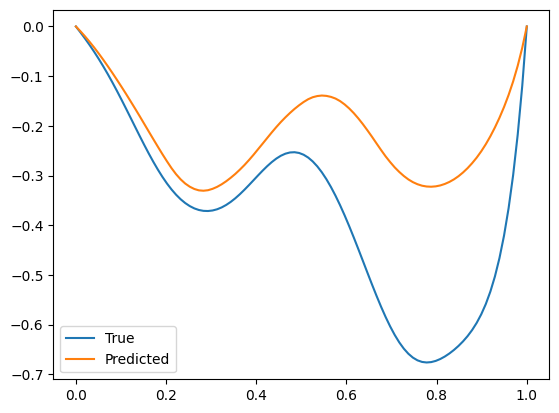

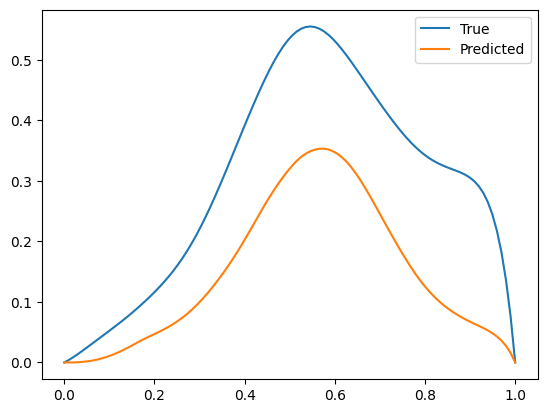

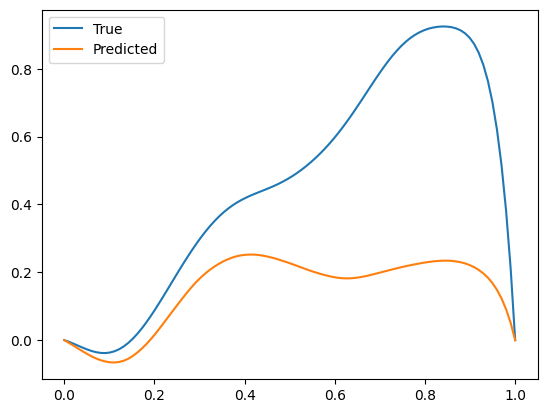

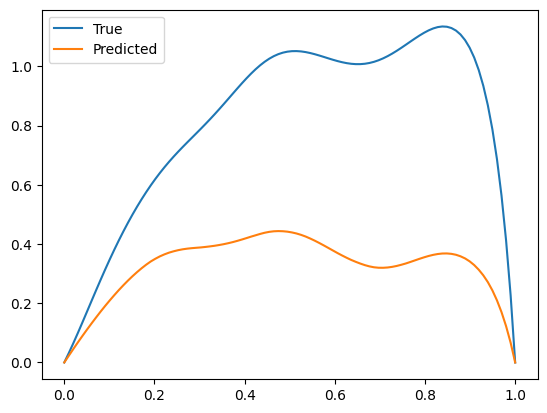

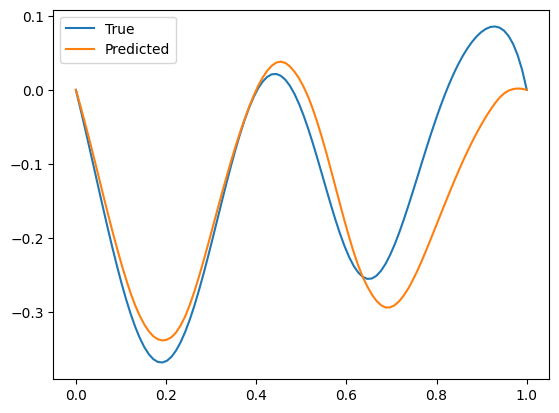

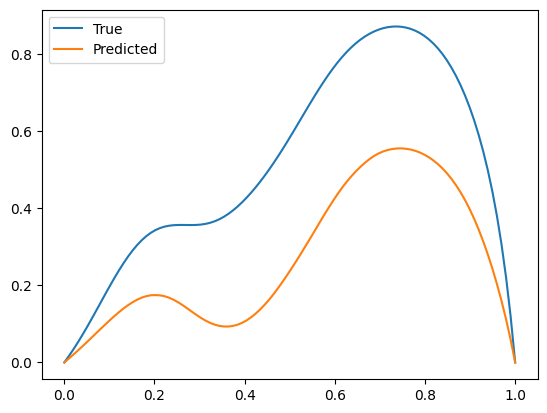

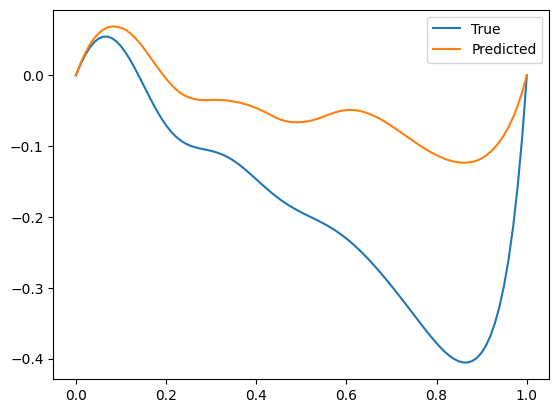

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:15:32,060 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:15:32,060 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.009589
2025-08-06 10:15:32,061 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.014422
Training progress:  10%|█         | 1/10 [00:03<00:34,  3.88s/it]2025-08-06 10:15:35,163 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:15:35,164 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.006478
2025-08-06 10:15:35,165 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.007182
Training progress:  20%|██        | 2/10 [00:06<00:27,  3.43s/it]2025-08-06 10:15:41,154 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:15:41,155 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.010066
2025-08-06 10:15:41,156 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.011183
Training progress:  30%|███       | 3/10 [00:12<00:32,  4.60s/i

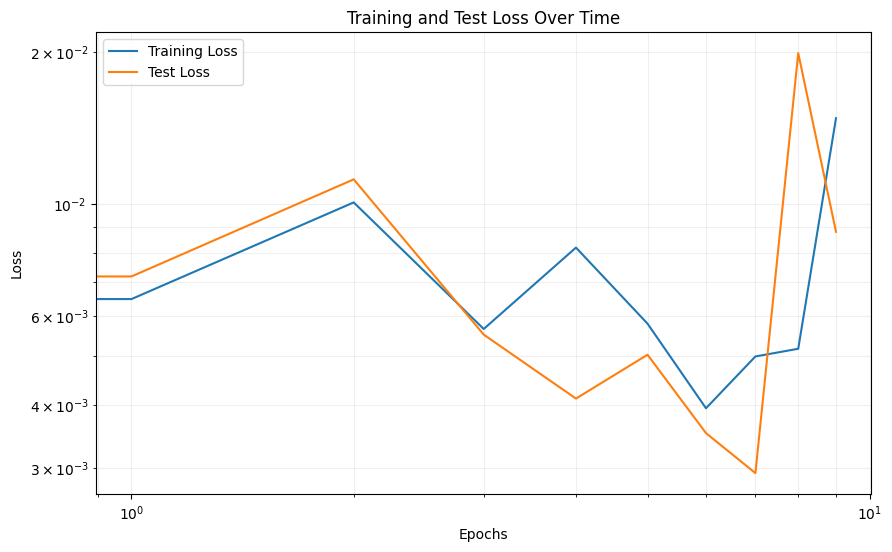

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


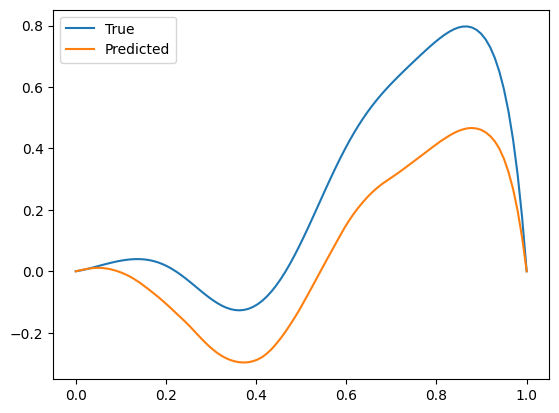

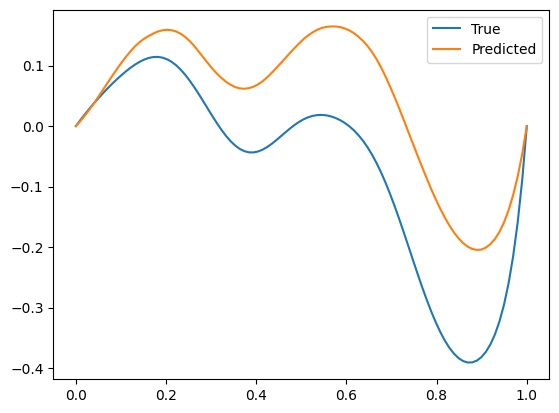

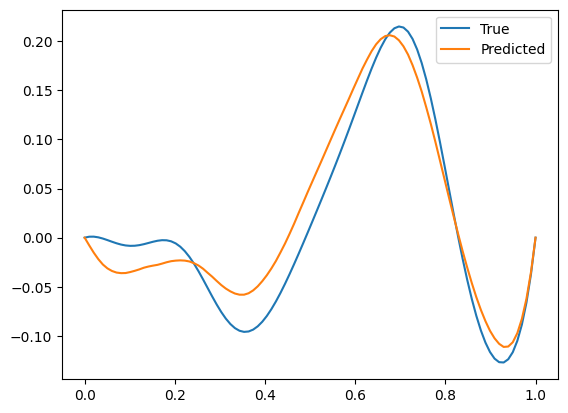

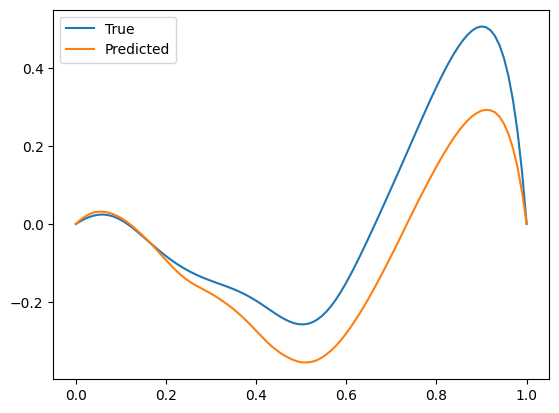

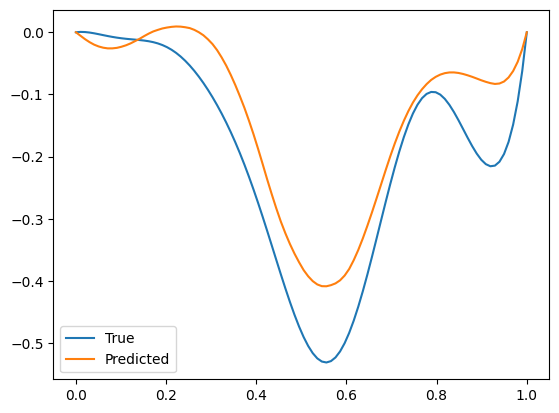

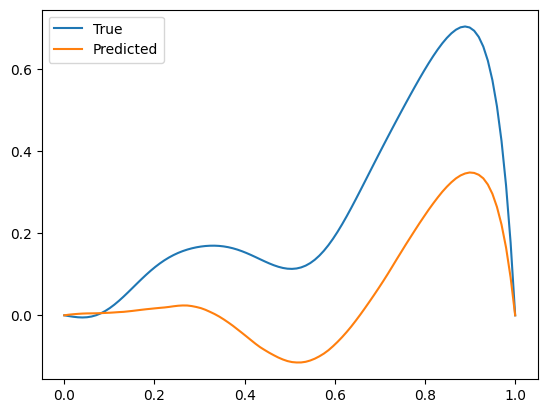

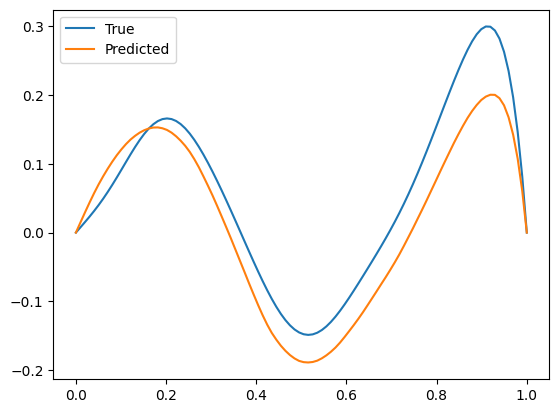

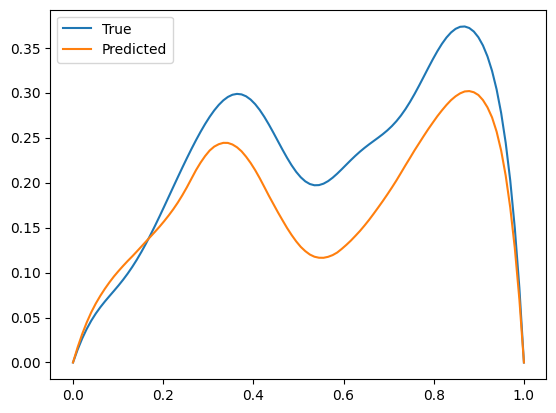

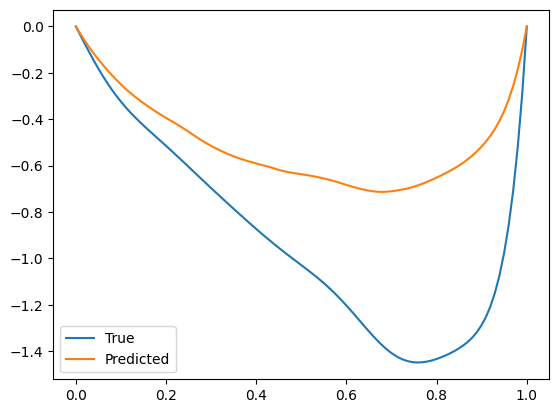

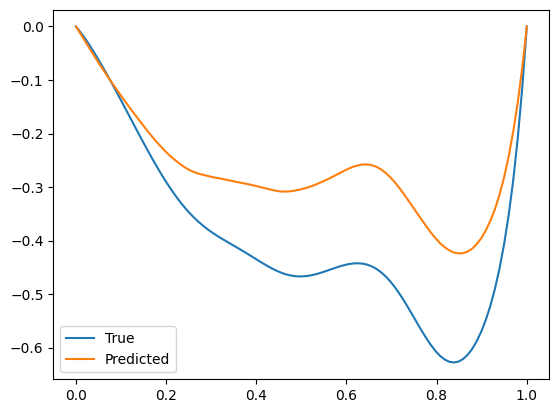

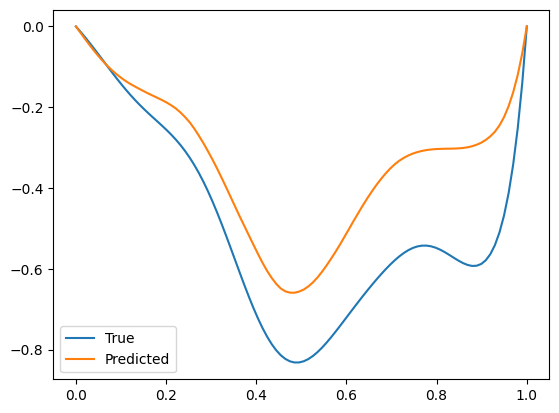

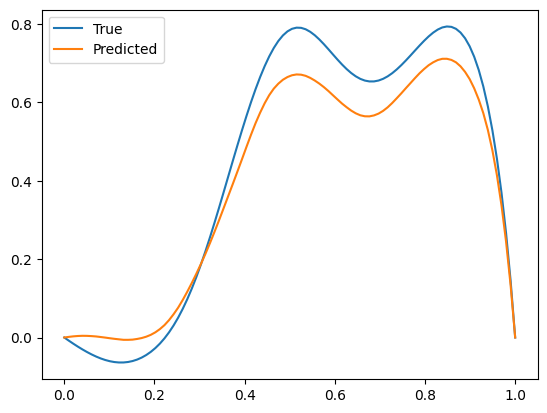

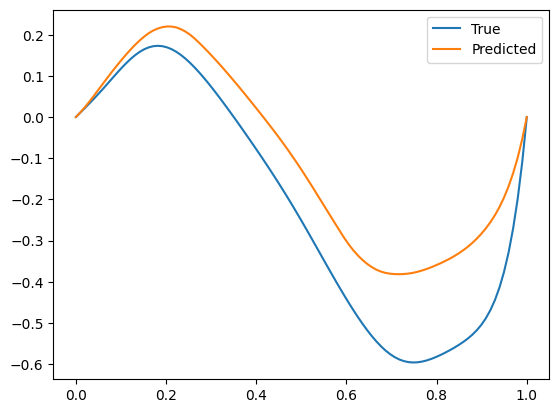

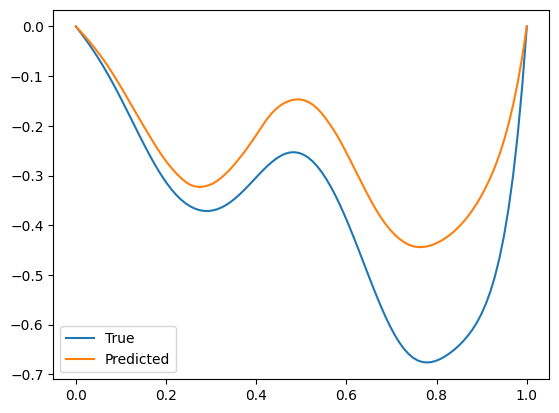

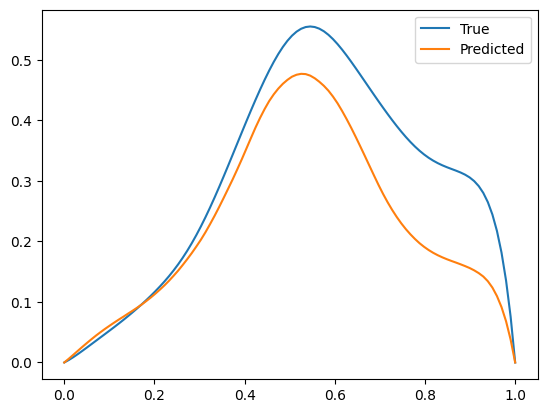

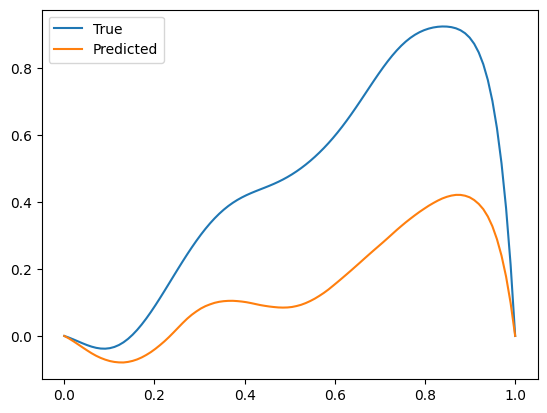

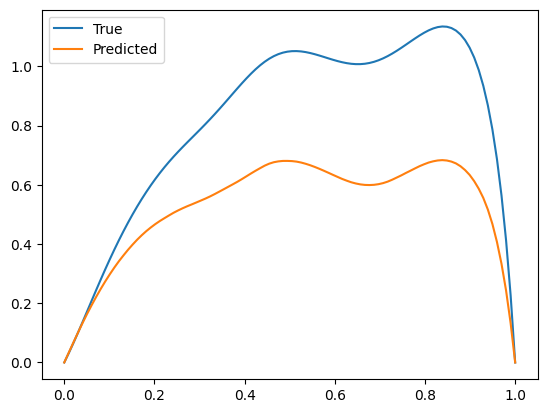

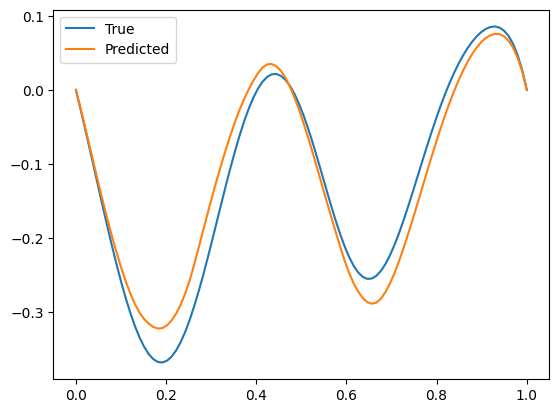

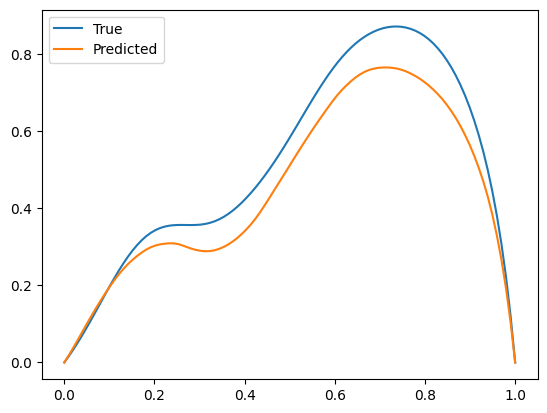

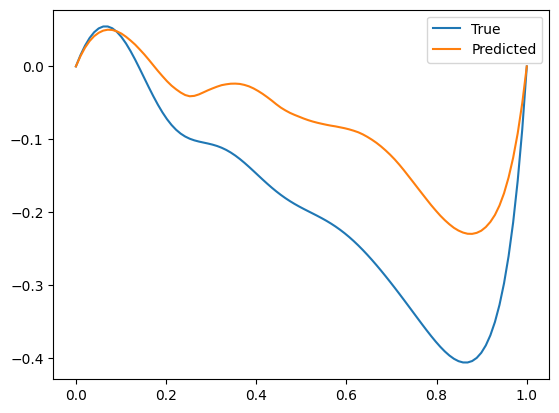

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:16:11,996 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:16:11,996 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.008152
2025-08-06 10:16:11,998 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.007295
Training progress:  10%|█         | 1/10 [00:04<00:44,  4.93s/it]2025-08-06 10:16:19,638 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:16:19,639 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.012176
2025-08-06 10:16:19,640 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.008756
Training progress:  20%|██        | 2/10 [00:12<00:52,  6.52s/it]2025-08-06 10:16:22,979 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:16:22,979 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.007811
2025-08-06 10:16:22,980 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.007235
Training progress:  30%|███       | 3/10 [00:15<00:35,  5.07s/i

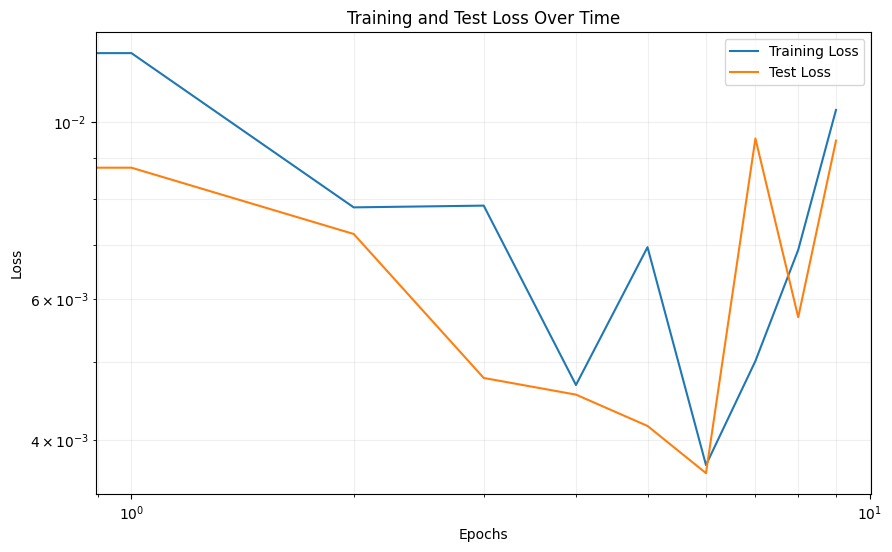

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


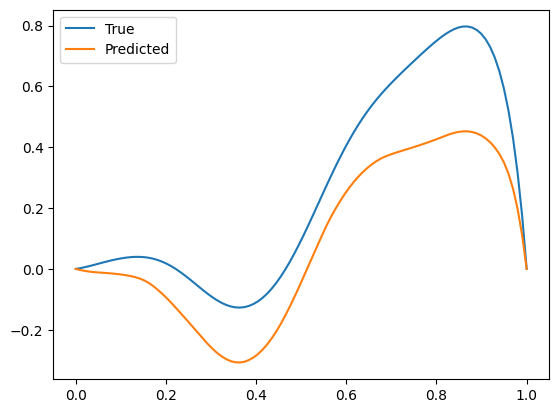

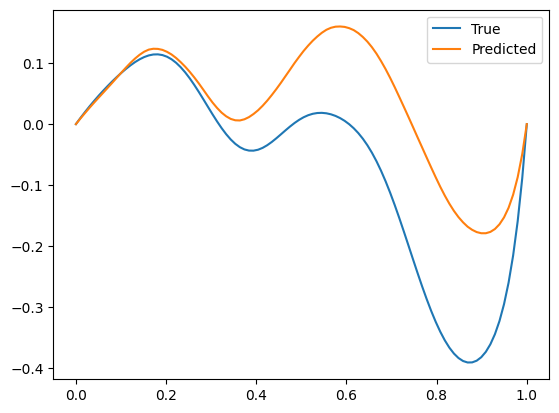

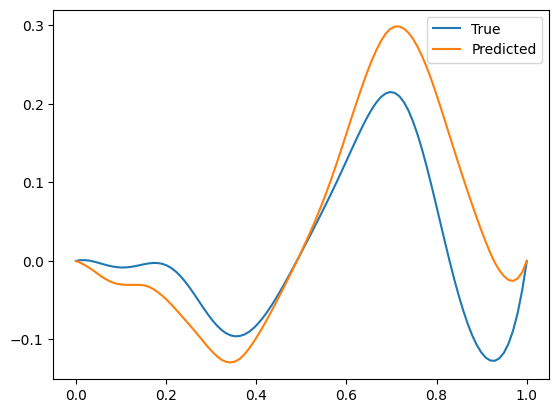

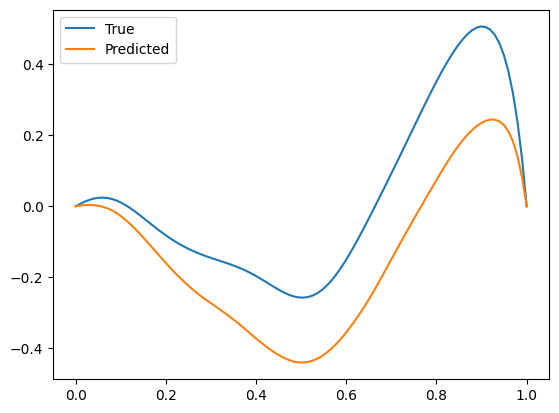

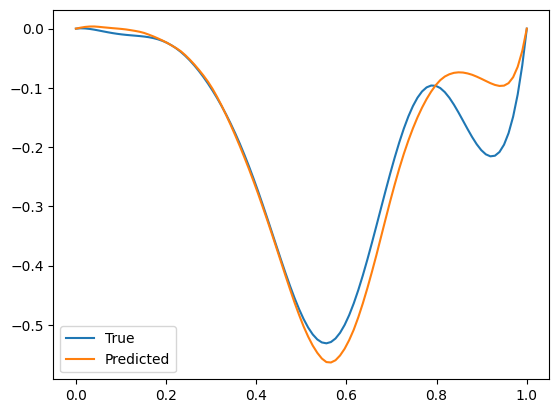

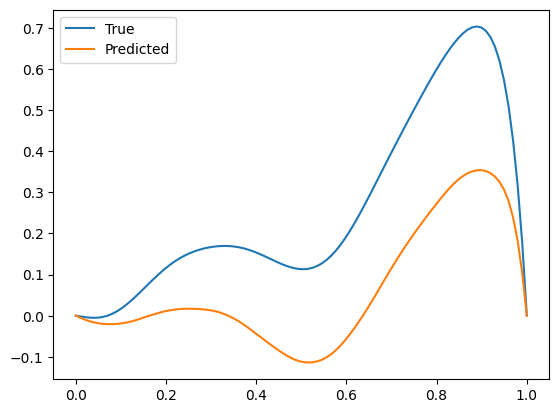

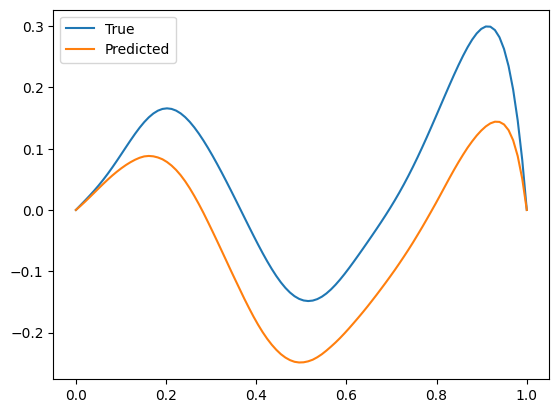

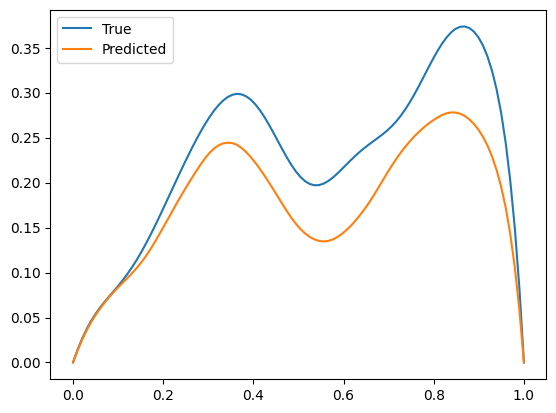

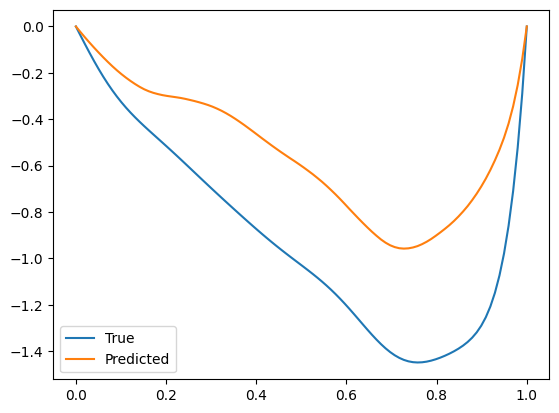

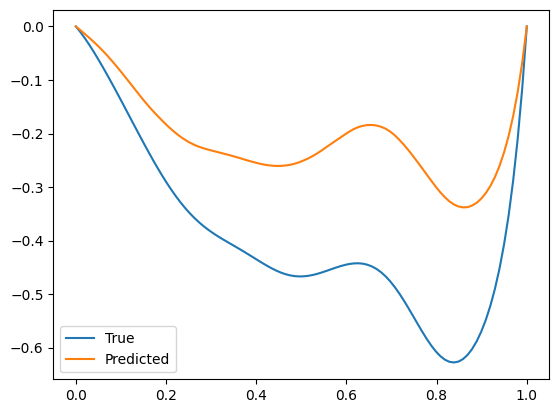

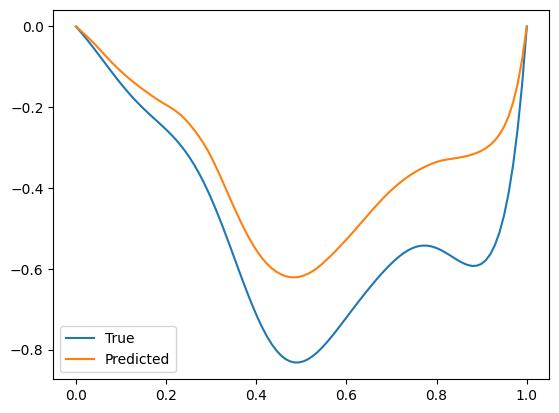

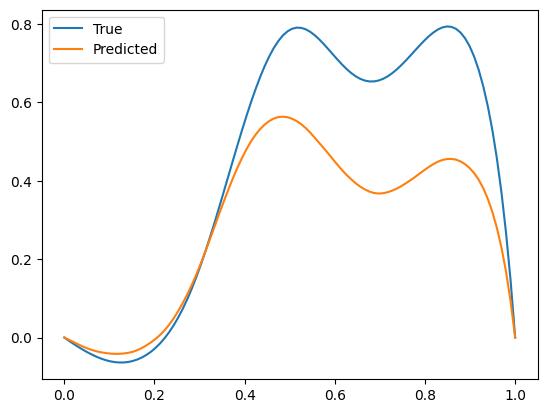

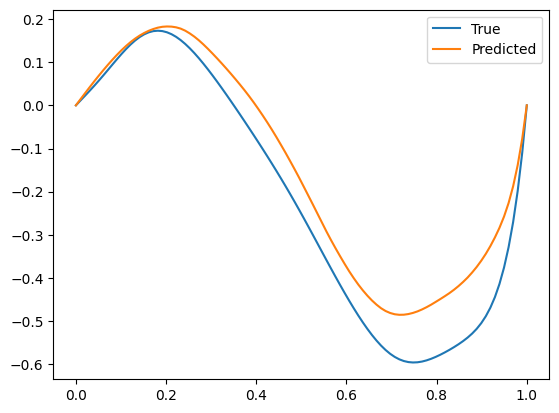

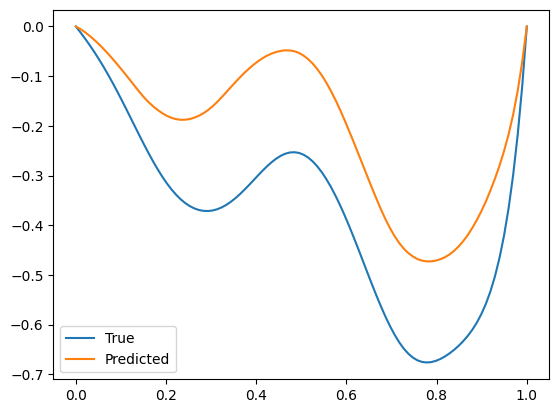

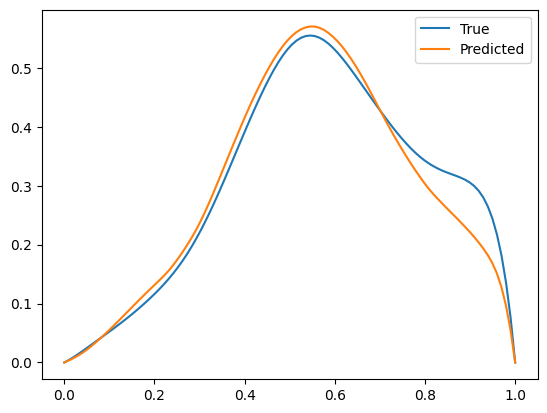

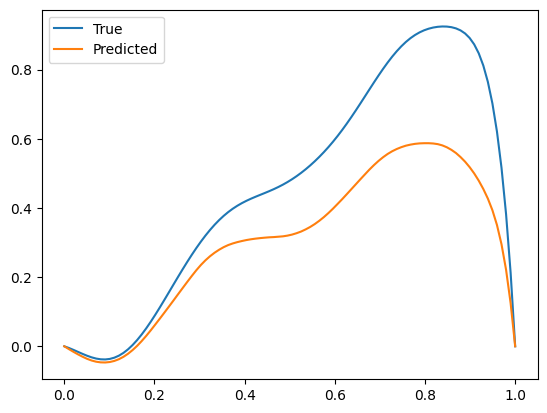

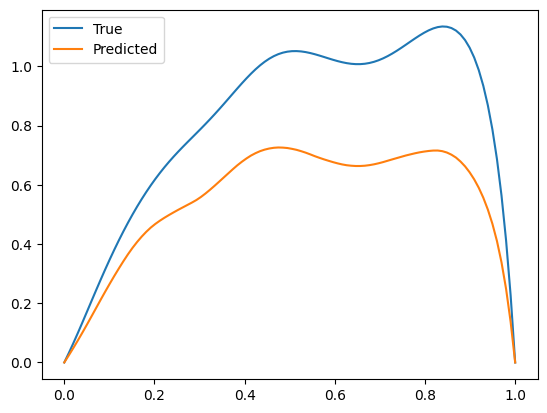

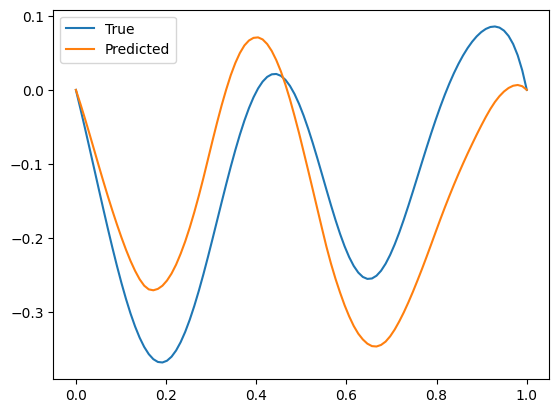

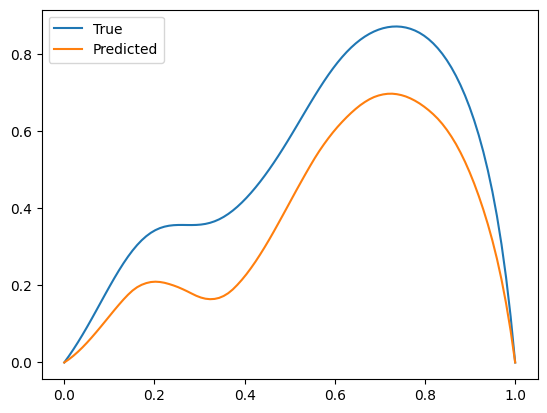

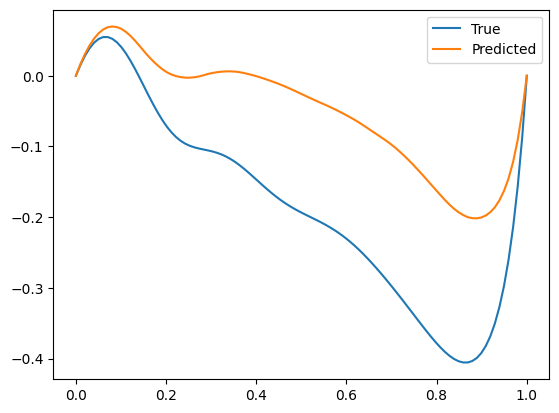

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 10:16:56,846 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 10:16:56,847 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.011847
2025-08-06 10:16:56,848 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.015181
Training progress:  10%|█         | 1/10 [00:04<00:42,  4.76s/it]2025-08-06 10:17:01,498 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 10:17:01,499 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.010838
2025-08-06 10:17:01,499 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.008245
Training progress:  20%|██        | 2/10 [00:09<00:37,  4.70s/it]2025-08-06 10:17:06,047 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 10:17:06,047 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.005435
2025-08-06 10:17:06,049 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.008107
Training progress:  30%|███       | 3/10 [00:13<00:32,  4.63s/i

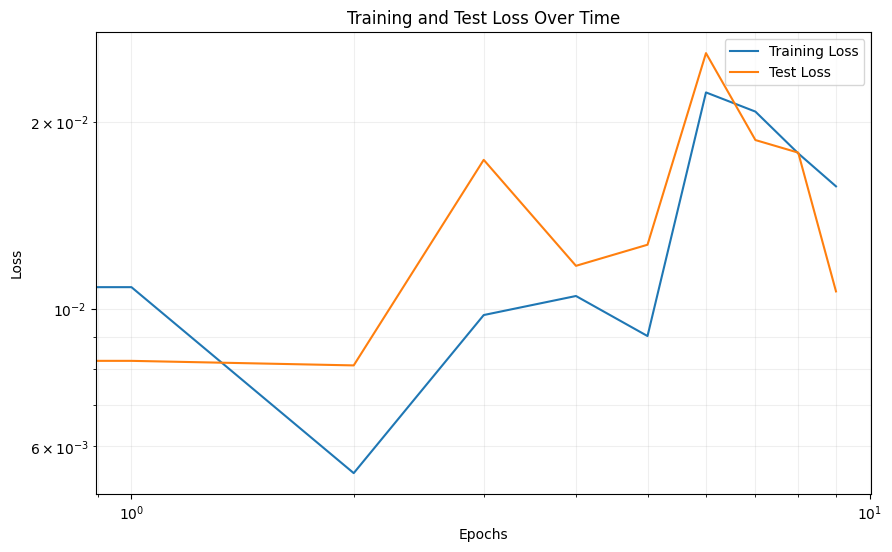

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


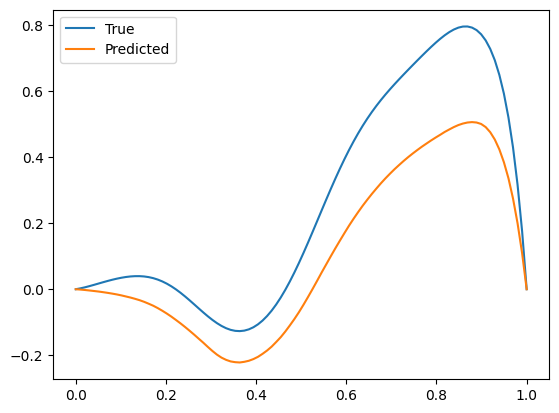

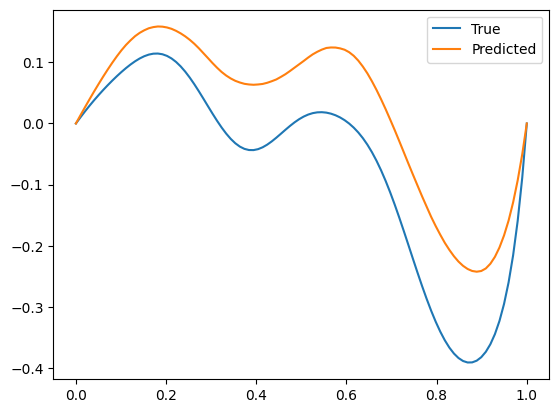

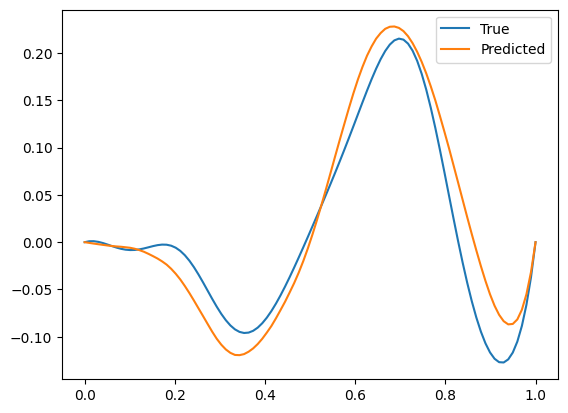

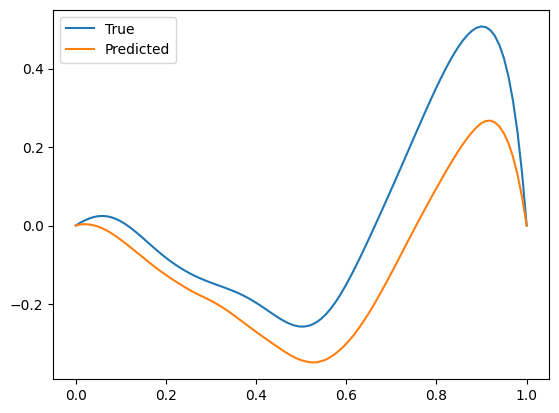

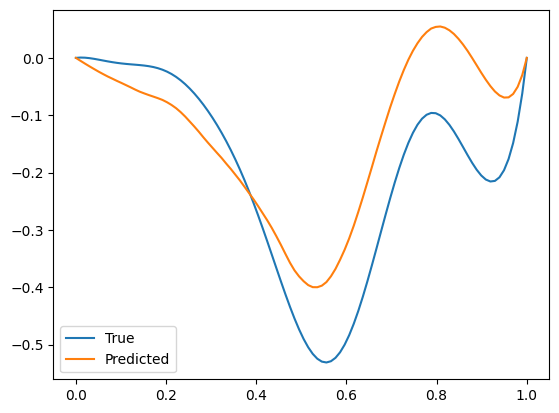

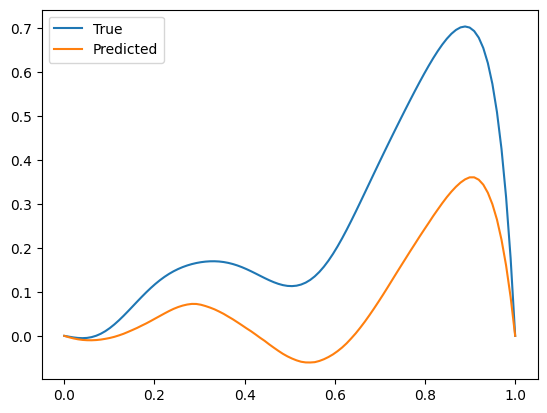

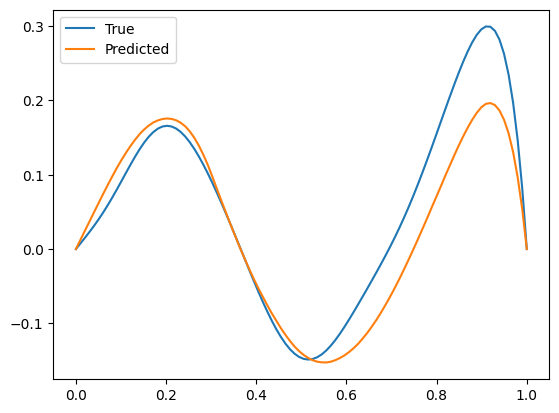

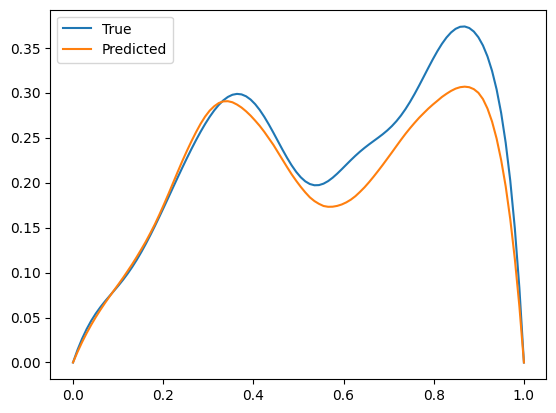

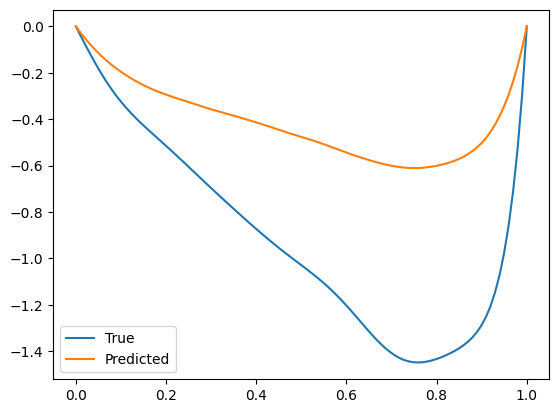

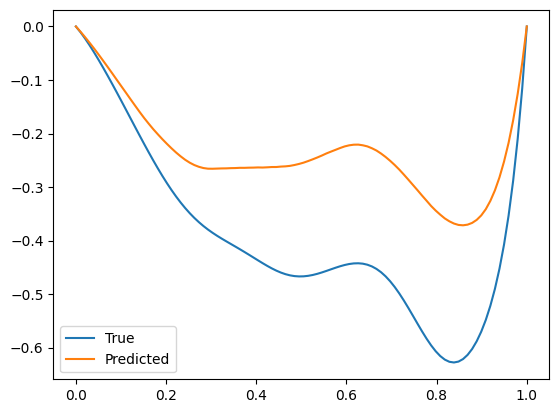

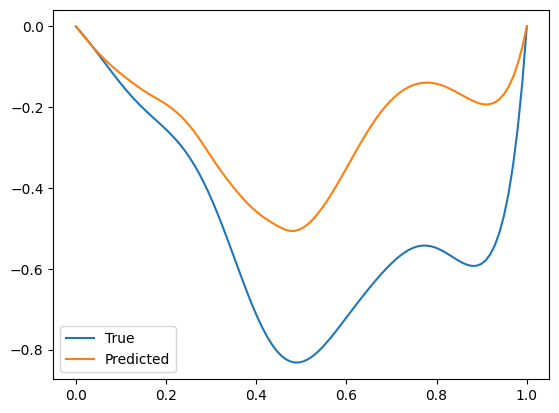

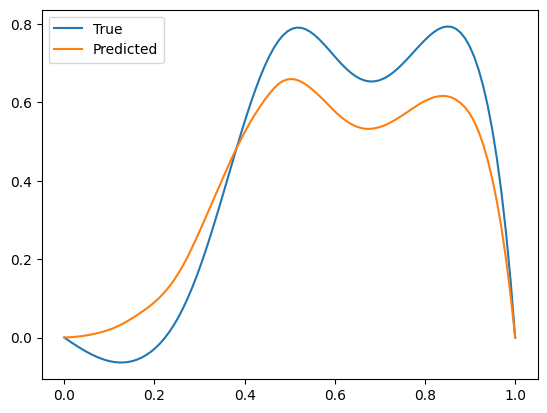

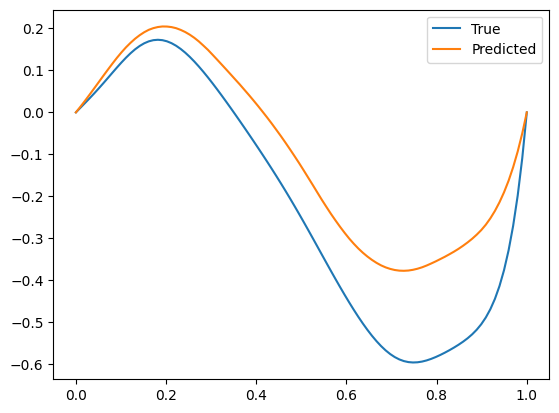

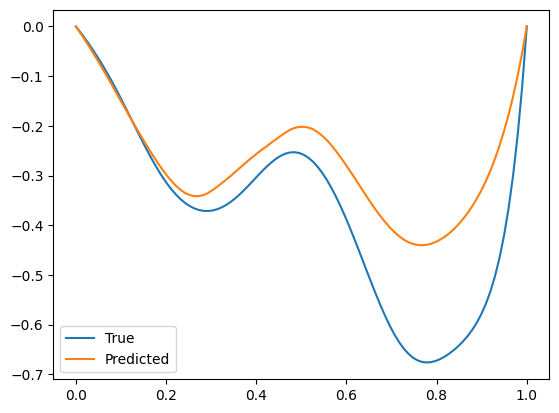

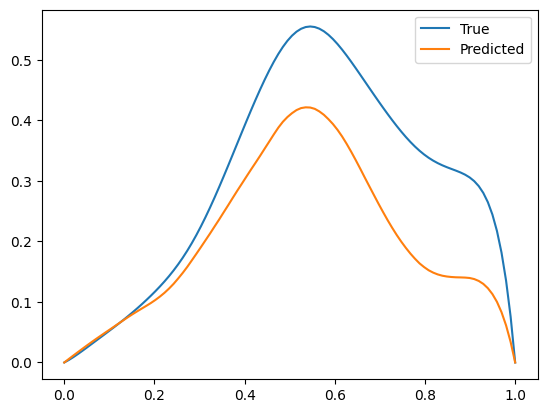

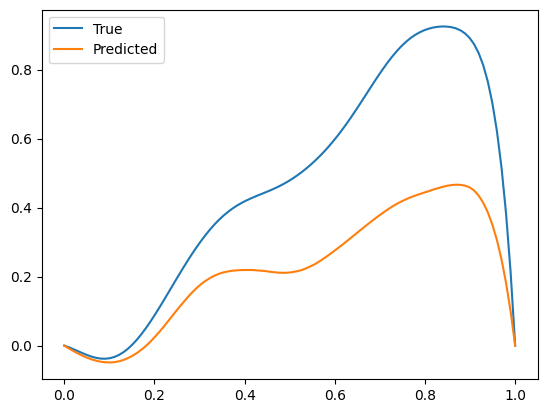

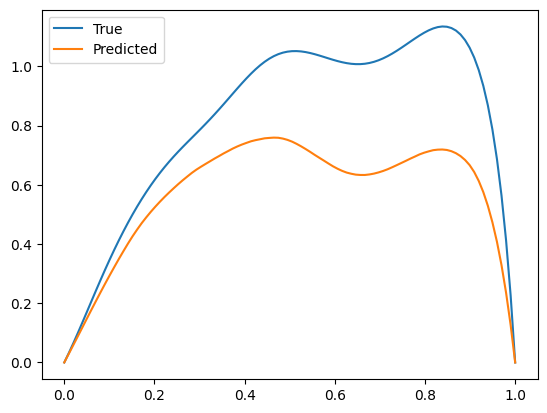

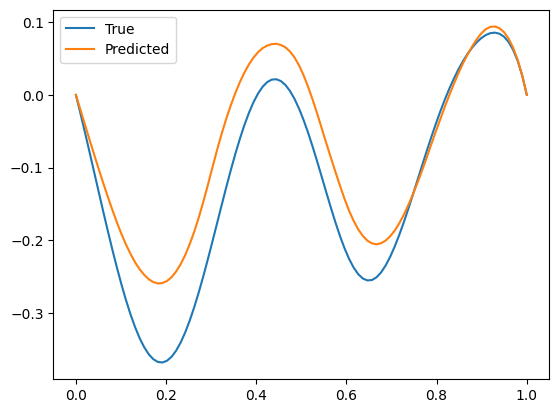

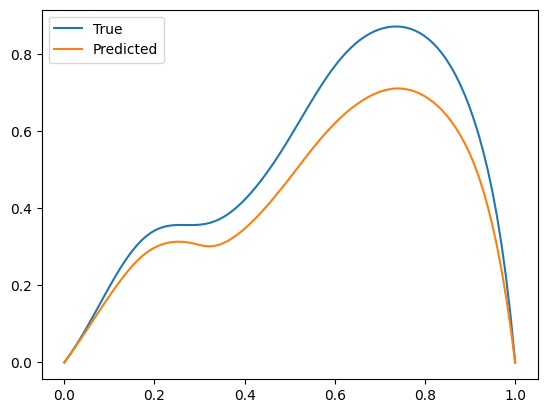

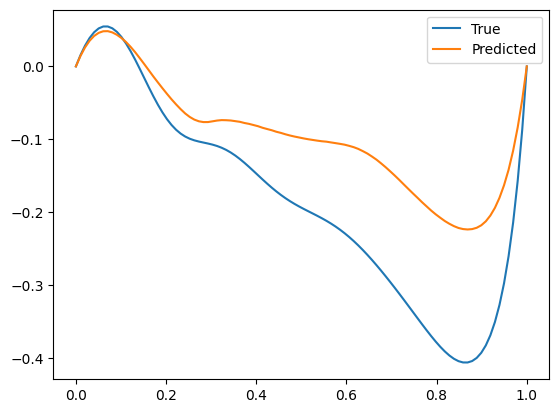

In [10]:
for _ in range(10):
    train_history = model.fit()
    plt.figure(figsize=(10,6))
    plt.plot(train_history[0], label='Training Loss')  # we plot training loss
    plt.plot(train_history[1], label='Test Loss')  # we plot test loss
    plt.yscale('log')  # we use log scale for better visualization
    plt.grid(True, which="both", ls="-", alpha=0.2)  # we add grid with transparency
    plt.xlabel('Epochs')  # we add x label
    plt.ylabel('Loss')  # we add y label
    plt.title('Training and Test Loss Over Time')  # we add title
    plt.legend()  # we add legend
    plt.yscale('log')
    plt.xscale('log')
    plt.show()
        
        # then we can test the model
    mu_test, xs_test, sol_test = get_mu_xs_sol(folder_path,0.2,training=False)

    preds = model.predict(mu_test, xs_test)
    for i in range(20):
        plt.plot(xs_test[i,:],sol_test[i,:], label='True')
        plt.plot(xs_test[i,:],preds[i,:], label='Predicted')
        plt.legend()
        plt.show()

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


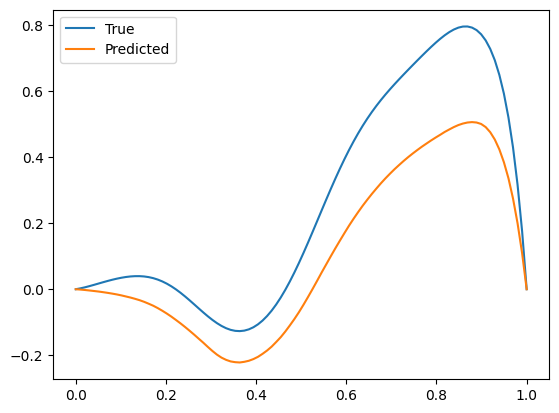

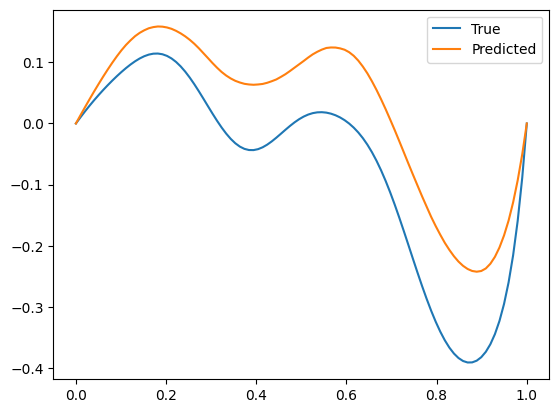

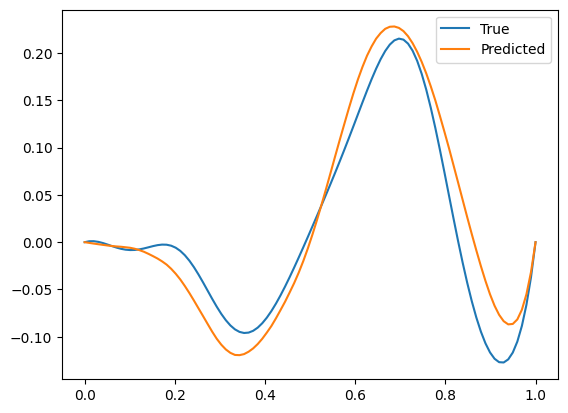

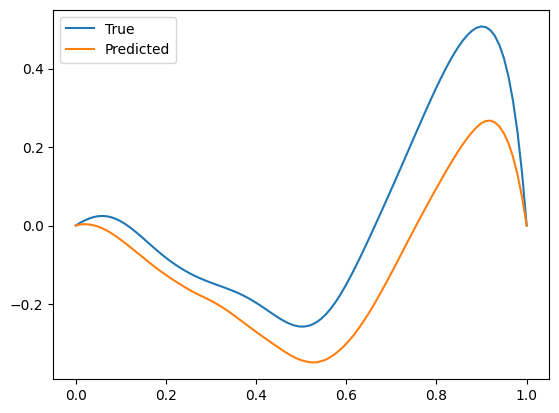

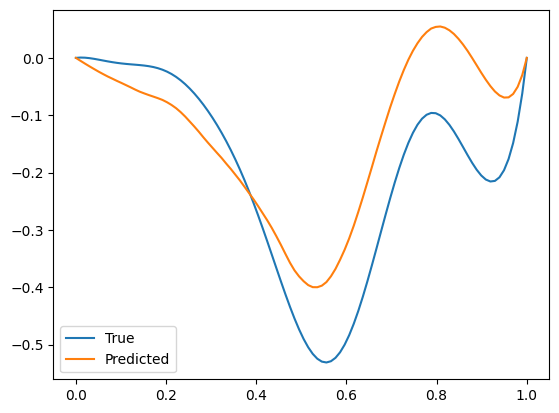

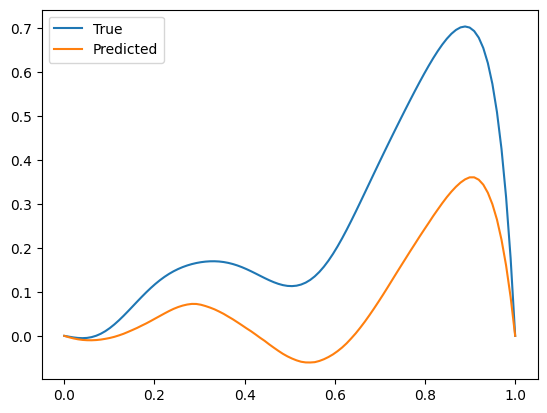

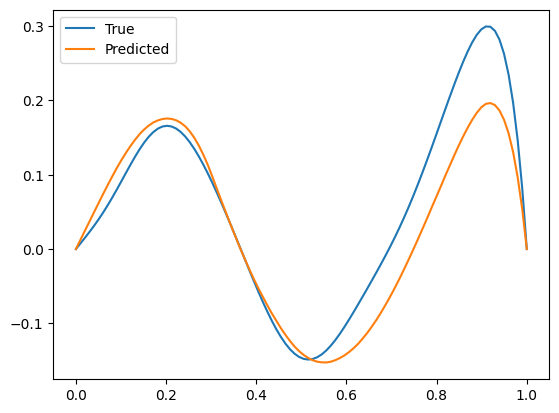

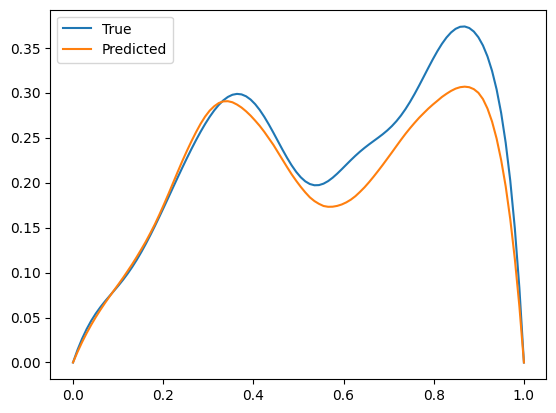

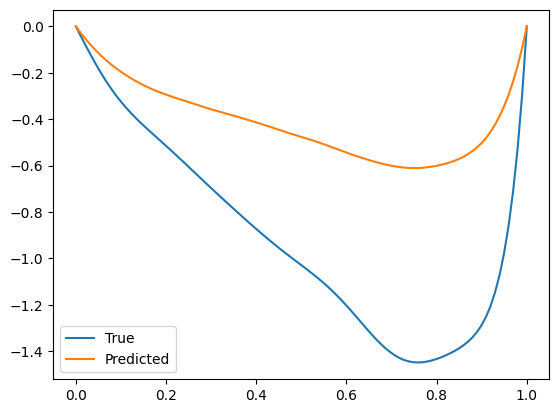

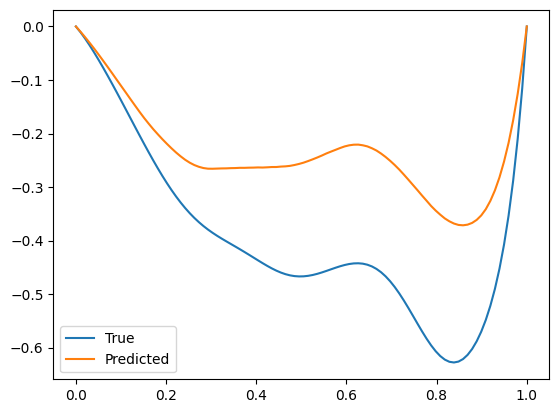

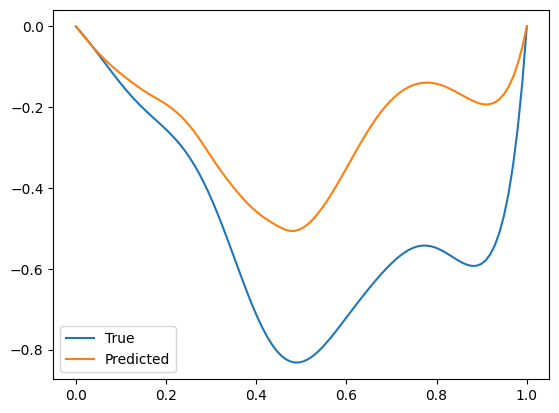

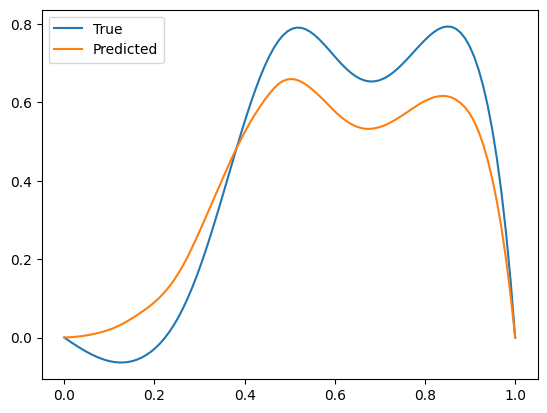

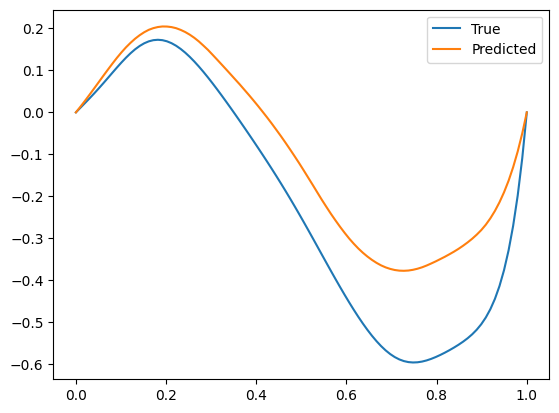

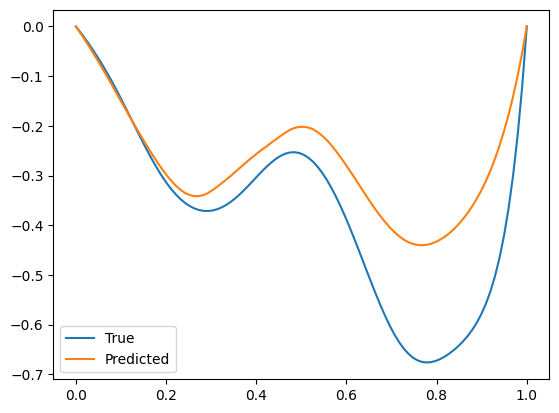

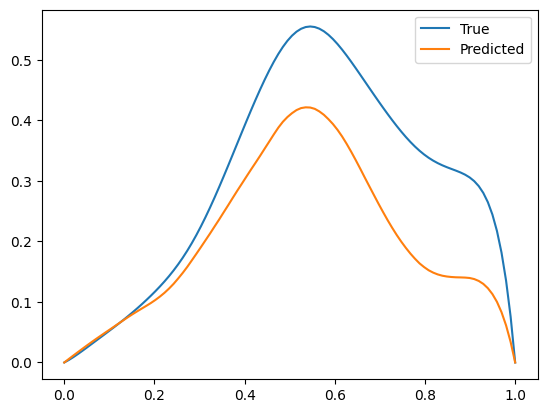

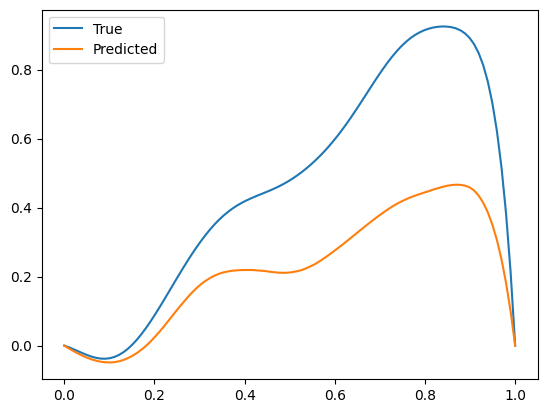

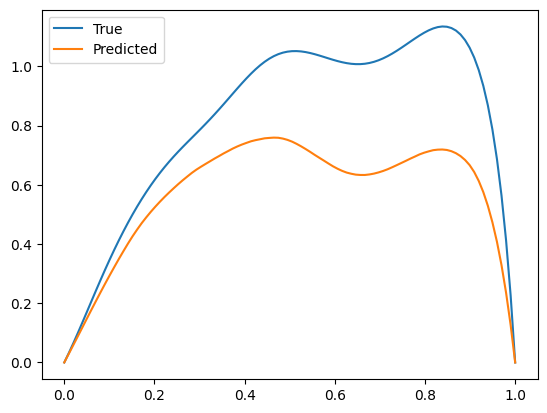

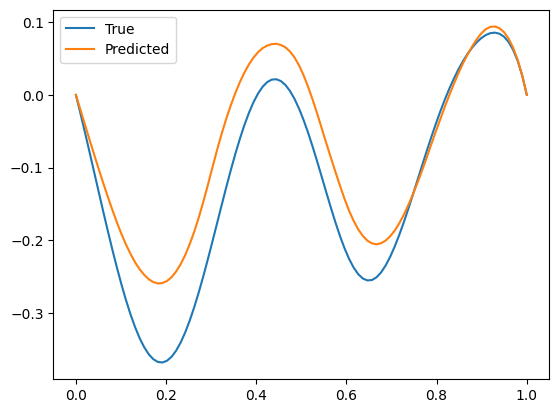

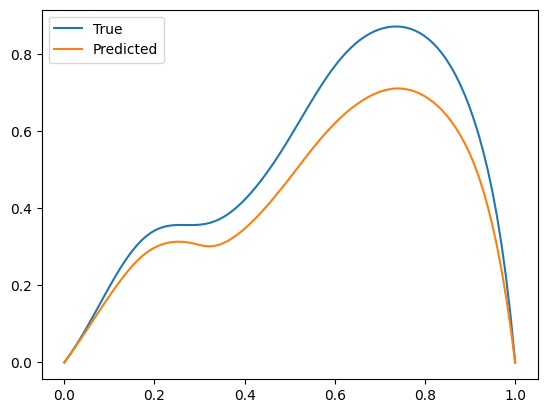

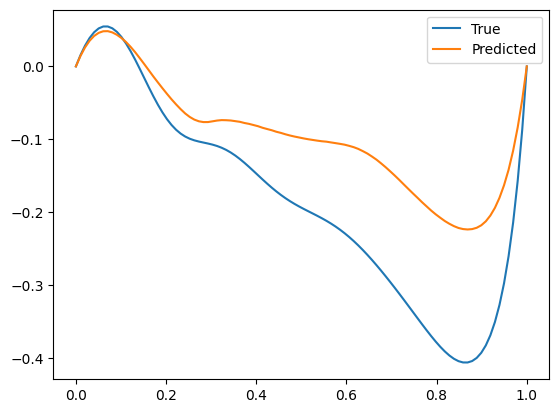

In [11]:
# then we can test the model
mu_test, xs_test, sol_test = get_mu_xs_sol(folder_path,0.2,training=False)

preds = model.predict(mu_test, xs_test)
for i in range(20):
    plt.plot(xs_test[i,:],sol_test[i,:], label='True')
    plt.plot(xs_test[i,:],preds[i,:], label='Predicted')
    plt.legend()
    plt.show()